# Compare Celerite fit to Chelsea fit : real light curves 

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
import seaborn as sns
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

[TLDR : Fig.11, comparing Celerite and Chelsea](#compareCelCh)

[Fig.10 : rest-frame distributions ](#restframeDisCelCh)

[Fig.12 : wavelength dependence ](#wavelength)

Using the results from most recent run : `190409_Celerite_real_Jeff1.npy`

In [150]:
# PRE-PROCESS the Celerite results from numpy dic --> astropy table
# and Chelsea results from a dat w/o SFinf --> astropy table 

# read in the results of just fitting the real LCs 
#fname = '../code/190228_Celerite_real_Jeff1.npy'190606_Celerite_real_Jeff1_1000.npy
#'190409_Celerite_real_Jeff1.npy' : using SDSS r and PS1 DR1 gri offset to SDSS synthetic r 
#190604 : using combined SDSS r and PS1 DR2 but all bands by mistake (not just r band )
fname = '190606_Celerite_real_Jeff1.npy'#  using combined SDSS r and PS1 DR2 r band ,
# removed 5 sigma errors and 5 sigma mags,  performed day-averaging...

r = np.load(fname).item() # it's only SDSS, SDSS-PS1 : two segments 

# convert a dict to a table, choosing relevant parts... 
seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)
t1_ = unique(t1, keys='lcname', keep='first')

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)
t2_ = unique(t2, keys='lcname', keep='first')

celerite =  join(t1_,t2_, keys='lcname', table_names=[seg[0] ,seg[1]])


celerite.write(fname[:-4]+'.txt', format='ascii')
print('Saved as ',fname[:-4]+'.txt' )

Saved as  190606_Celerite_real_Jeff1.txt


For these LCs, get the number of points before and after 5-sigma clipping and day-averaging in bnoth SDSS and PS1 segments ....

In [179]:
data = Table.read('190606_Celerite_real_Jeff1.txt', format='ascii')

data['N_SDSS_raw'] = 0
data['N_PS1_raw'] = 0
data['N_SDSS_clean'] = 0 
data['N_PS1_clean'] = 0 

for i in range(len(data['lcname'].data)) :
    lcname = data['lcname'].data[i]    
    # grab N pts before for SDSS and PS1 
    combinedDir = '../dp2/real_sdss_ps1r_dr2/'
    lc0 = Table.read(combinedDir + lcname, format='ascii')
    values, counts = np.unique(lc0['survey'].data, return_counts=True)
    for value in values : 
        data['N_'+value.upper()+'_raw'][i] = counts[values == value]

    # grab N pts after ... 
    cleanedDir = '../dp2/real_sdss_ps1r_dr2_cleaned/'
    lc1 = Table.read(cleanedDir + lcname , format='ascii')
    values, counts = np.unique(lc1['survey'].data, return_counts=True)
    for value in values : 
        data['N_'+value.upper()+'_clean'][i] = counts[values == value]

In [181]:
data.write('190606_Celerite_real_Jeff1_Npts.txt', format='ascii')

In [170]:
counts[values == 'sdss']


array([64])

In [163]:
counts

array([12, 64])

Plot $\tau_{SDSS}$ vd $\tau_{SDSS-PS1}$ : 

Celerite_190606_timescales_N.png


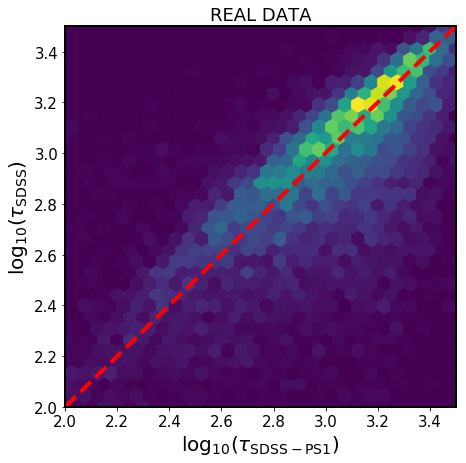

In [187]:
%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(7,7))
ax.hexbin(np.log10(data['tauEXP_sdss-ps1']), 
          np.log10(data['tauEXP_sdss']), 
          extent=(2.0,3.5,2.0,3.5),
         gridsize=30)
ax.set_xlabel(r'$\log_{10}{(\tau_{\mathrm{SDSS-PS1}})}$')
ax.set_ylabel(r'$\log_{10}{(\tau_{\mathrm{SDSS}})}$')
x  = np.linspace(2.0,3.5,100)
ax.plot(x,x,ls='--',lw=4, color='red')
ax.set_title('REAL DATA', fontsize=18)
figname = 'Celerite_'+fname[:6]+'_timescales_N.png'
print(figname)
plt.savefig(figname, bbox_inches='tight', dpi=100)

In [4]:
# For some reason some light curves have been fit multiple times.
# Can't see atm why, but the results are 
# the same , so just remove duplicates 
names, count = np.unique(t2['lcname'], return_counts=True)
t2[t2['lcname'] == names[count==3][3]]

<Table masked=True length=3>
   lcname         length      ...       tauEXP             tauMAP     
   str11         float64      ...      float64            float64     
----------- ----------------- ... ------------------ -----------------
1708411.txt 5232.903164999996 ... 1915.3791160875835 1041.994821295959
1708411.txt 5232.903164999996 ... 1915.3791160875835 1041.994821295959
1708411.txt 5232.903164999996 ... 1915.3791160875835 1041.994821295959

Just plot Celerite, and compare how the overall distribution shift : 

Median log10(sigma_sdss-ps1/sigma_sdss)= 0.03468898672577632
Mean log10(sigma_sdss-ps1/sigma_sdss)= 0.06628527842127459
Median log10(tau_sdss-ps1/tau_sdss)= 0.018738616308615876
Mean log10(tau_sdss-ps1/tau_sdss)= 0.07688174324493488


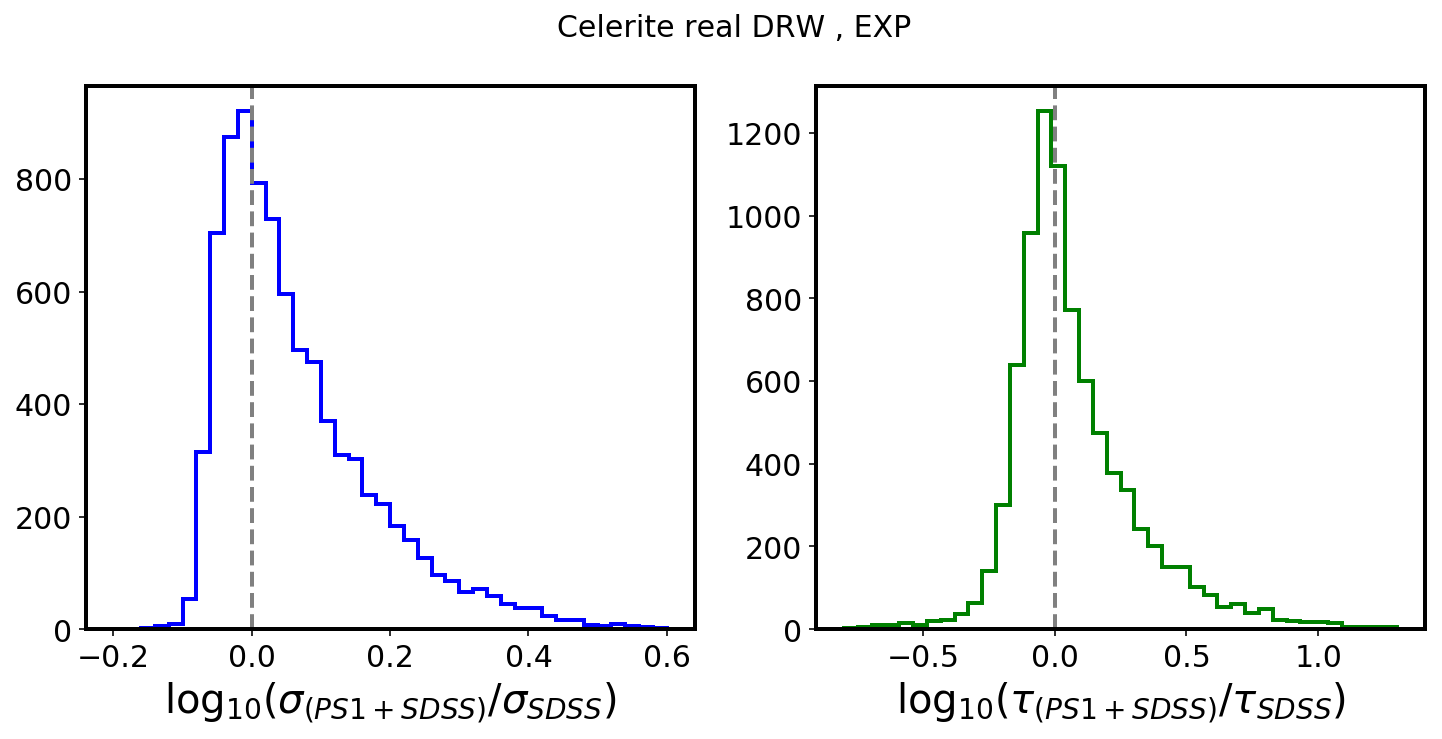

In [42]:
%config InlineBackend.figure_format='retina'
# plot changes in tau only for QSO for which Chelsea was more certain...

data = celerite
# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

fit='EXP'

fig,ax = plt.subplots(1,2, figsize=(12,5))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []

i = 0

labels = {'sigma': r'$\log_{10}{(\sigma_{(PS1+SDSS)} / \sigma_{SDSS})}$',
         'tau':r'$\log_{10}{(\tau_{(PS1+SDSS)} / \tau_{SDSS})}$'}

#m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
#m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
#m4 = s82r['edge'] == 0 
#m = m2&m3&m4

m = celerite['tauEXP_sdss'] > 5

ranges = {'sigma':[-0.2,0.6], 'tau':[-0.8,1.3]}

for q in ['sigma','tau']:
    m = data['tau'+fit+'_sdss-ps1'] > 5 
    x = (data[q+fit+'_sdss-ps1'][m] )/ data[q+fit+'_sdss'][m]
    ax[i].hist(np.log10(x), histtype='step', 
               bins=40, range=ranges[q], color = colors[i],lw=2) 
    
    print('Median log10('+q+'_sdss-ps1/'+q+'_sdss'+')=', np.median(np.log10(x)))
    print('Mean log10('+q+'_sdss-ps1/'+q+'_sdss'+')=', np.mean(np.log10(x)))
    
    ax[i].set_xlabel(labels[q])
    ax[i].axvline(0, lw=2, ls='--', c='grey')
    i += 1 

fig.suptitle('Celerite real DRW , '+ fit , fontsize = 15)
plt.savefig('Celerite_real_DRW_EXP_compare_tau_NEW.png', bbox_inches='tight')

Just Celerite:  what are the $\rho_{out}$ values ? 

Text(0.5, 0, '$\\rho_{fit} = \\tau_{\\mathrm{fit}} / \\mathrm{baseline}$')

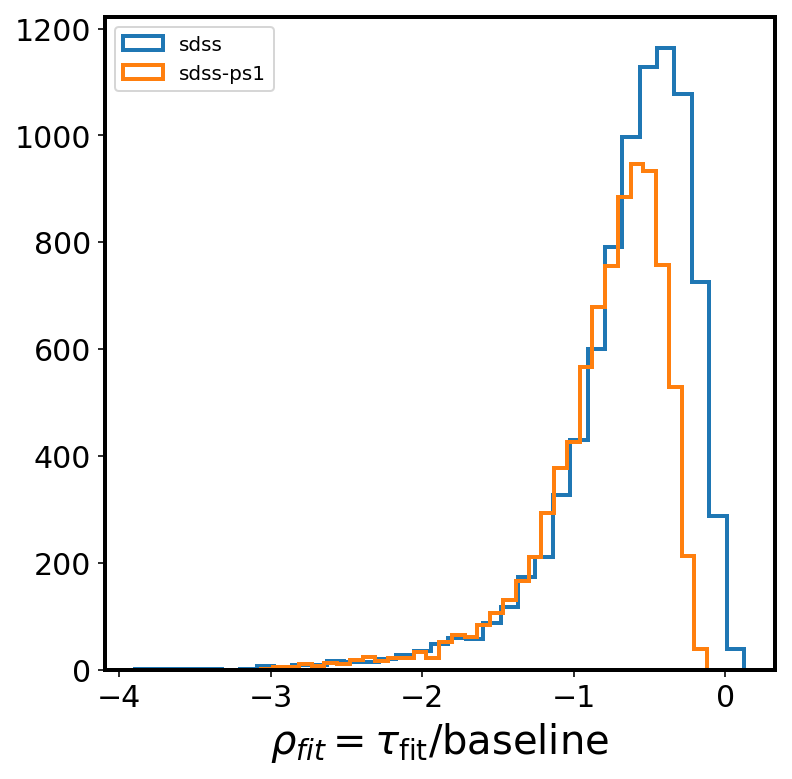

In [43]:
segs = ['sdss', 'sdss-ps1']
m = s82r['tauEXP_sdss-ps1'] > 5
fig,ax = plt.subplots(1,1,figsize=(6,6))
for seg in segs:
    rho = s82r['tauEXP_'+seg][m] / s82r['length_'+seg][m]
    ax.hist(np.log10(rho), histtype='step',lw=2, label=seg, bins=35)
ax.legend(loc='upper left')
ax.set_xlabel(r'$\rho_{fit} = \tau_{\mathrm{fit}} / \mathrm{baseline}$')

Add to Celerite Shen2008 (DBQSO), and Shen2011. Then also add Chelsea's r-band results 

Crossmatch Chelsea's r-band results to Celerite results : 

In [34]:
# add a column with int  DR7  dbID  for SDSS QSO 
dbID = np.asarray([x[:-4] for x in celerite['lcname']]).astype(int)
celerite['dbID']  = dbID

# add the info about qso from DR7 catalog to have ra, dec 
#  SDSS s82r  9258  DR7 QSOs from Shen+2008
# from http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_s82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dr7 = Table.read(File, format='ascii', names = colnames)
celerite_dbqso = join(celerite, dr7, keys='dbID')

name = fname[:-4]+'_radec.txt'
celerite_dbqso.write(name, format='ascii', overwrite=True) 
print('Added to Celerite DBQSO. Saved as ', name)


# read in Shen+2011 to add to the resutls ....
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]


cat1 = SkyCoord(ra=celerite_dbqso['ra']*u.degree, 
                dec=celerite_dbqso['dec']*u.degree)
cat2 = SkyCoord(ra=shen2011['RA']*u.degree,
                dec=shen2011['DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
# Celerite x-matched to Shen2008 (DBQSO) and Shen2011 - all catalogs 
celerite_cats = hstack([celerite_dbqso, shen2011[idx]])
name = fname[:-4]+'_Shen2008-2011.txt'
celerite_cats.write(name, format='ascii', overwrite=True)
print('Added to Celerite DBQSO and Shen2011. Saved as ', name)

# read in Chelsea's results ... 
s82drw = Table.read('../code/s82drw_r.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
# add a column with SFinf in mags 
# sigmahat  =  SFinf / sqrt(tau)
# but she did it for tau in years ,
# so need to convert to days 
s82drw['SFinf'] = np.power(10,s82drw['log10sigmahat']) *\
     np.sqrt(np.power(10,s82drw['log10tau']) / 365.)
    
    
# add a column with lambda RF 
s82drw['lambdaRF'] = 6250 /  (1.+ s82drw['redshift'])
s82drw.write('s82drw_r_table.txt', format='ascii', overwrite='True')


# Read in Chelsea's r-band results 
# And Celerite real LC results,
# cross-matched with DB_QSO_DR7  for ra,dec 
#celerite = Table.read('190228_Celerite_real_Jeff1_2000_table_radec.txt', format='ascii')
#chelsea = Table.read('s82rdrw_r_table.txt', format='ascii')
celerite = celerite_cats
chelsea = s82drw

# cross-match Celerite to Chelsea 
cat1 = SkyCoord(ra=celerite['ra']*u.degree, 
                dec=celerite['dec']*u.degree)
cat2 = SkyCoord(ra=chelsea['ra']*u.degree,
                dec=chelsea['dec']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
s82r = hstack([celerite, chelsea[idx]])
name = fname[:-4]+'_Shen2008-2011_s82drw_r.txt'
s82r.write(name, format='ascii', overwrite='True')
print('Added to Celerite DBQSO, Shen2011 and Chelsea s82drw r-band . Saved as ', name)




Added to Celerite DBQSO. Saved as  190606_Celerite_real_Jeff1_radec.txt
Added to Celerite DBQSO and Shen2011. Saved as  190606_Celerite_real_Jeff1_Shen2008-2011.txt
Added to Celerite DBQSO, Shen2011 and Chelsea s82drw r-band . Saved as  190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt


Note: of 6444 Quasars for which I have combined light curves,  **only 4828 **Chelsea would trust, because they don't have runaway timescales and the likelihood for DRW is better than the likelihood for noise (this is for SDSS-PTF-PS1-CRTS inner join).

Note: if using the outer join, i.e. eg. light curves that have SDSS-PS1 data, but not CRTS, or PTF,  we boost the numbers to 7624 that Chelsea would have trusted (from her fits) of 

## Compare Celerite and Chelsea  <a id='compareCelCh'></a>

In [64]:
#s82r = Table.read('190409_Celerite_real_Jeff1_radec_s82drw_r.txt', format='ascii')
#s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
s82r = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')

m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
m4 = s82r['edge'] == 0 

m = m2&m3&m4
print(np.sum(m), ' of ', len(m))
# haha! now there are 6975 QSO that Chelsea would have trusted ... 

6389  of  8516


Plot the residuals  $\Delta(\mathrm{Chelsea}-\mathrm{Celerite})$ : 

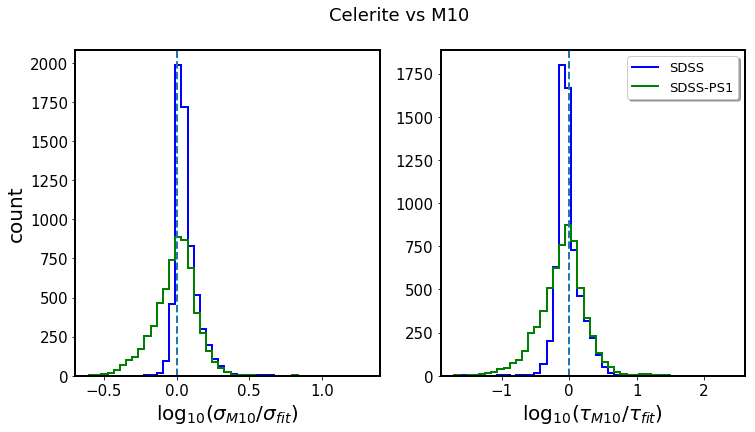

In [59]:
%matplotlib inline

colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []

fig,ax = plt.subplots(1,2,figsize=(12,6))
x1a =  s82r['SFinf'][m] / np.sqrt(2)
x1b = np.power(10, s82r['log10tau'][m]) 
i =0 
for f in ['EXP']:
    for seg in ['sdss','sdss-ps1']:
        
        x2 = s82r['sigma'+f+'_'+seg][m] 
        #ax[0].hist(np.log10(x1-x2), histtype='step')
        ax[0].hist(np.log10(x1a/x2), range=(-0.6,1.3),histtype='step',lw=2,
                  color = colors[i], bins=45)
        
        x2 = s82r['tau'+f+'_'+seg][m]
        ax[1].hist(np.log10(x1b/x2),range=(-1.7,2.4), histtype='step',lw=2,
                  color = colors[i],bins=45)
        # 
        line = mlines.Line2D([], [],  color=colors[i], label= seg.upper(),lw=2)
        ax_legend_handles.append(line)
        i += 1 
        
ax[0].set_ylabel('count')

ax[1].legend(loc='upper right', handles = ax_legend_handles,
             bbox_to_anchor=(1.0, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=13 ) 
#for seg in ['sdss', 'sdss-ps1']:
    
    #ax[1].hist(np.log10(x1-x2), histtype='step')
   # ax[1].hist(np.log10(x1/x2), range=(-0.5,1.1),histtype='step',lw=2)
ax[0].axvline(0, ls = '--', lw=2)
ax[1].axvline(0,ls = '--', lw=2)
ax[0].set_xlabel(r'$\log_{10}{\left( \sigma_{M10} / \sigma_{fit} \right)}$')
ax[1].set_xlabel(r'$\log_{10}{\left( \tau_{M10} / \tau_{fit}\right)}$')
fig.suptitle('Celerite vs M10', fontsize=18)
plt.savefig('Compare_Chelsea_r-band_Celerite_'+seg+'_EXP_NEW.png', bbox_inches='tight')

Plot as 2D hist to make it on a single panel ... 




Compare_Celerite_SDSS-PS1_vs_SDSS_EXP.png


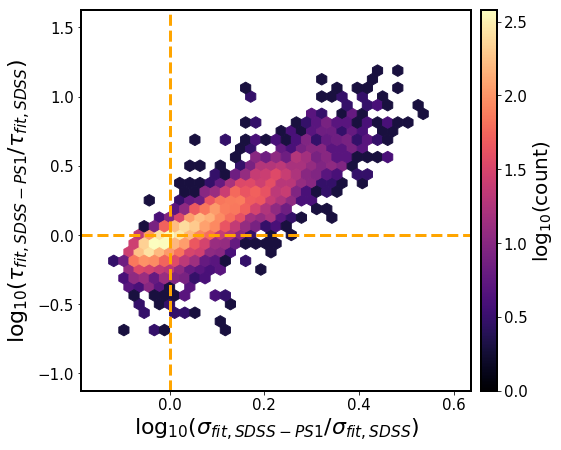

In [13]:
%matplotlib inline
import matplotlib as mpl
fig,ax = plt.subplots(1,1,figsize=(7,7))
#sigM10 =  s82r['SFinf'][m] / np.sqrt(2)
#tauM10 = np.power(10, s82r['log10tau'][m]) 


seg = 'sdss-ps1'
sigCel = s82r['sigmaEXP_'+seg][m] 
tauCel = s82r['tauEXP_'+seg][m] 

comp_to_chelsea = False 
if comp_to_chelsea : 
    x  = np.log10(sigCel / sigM10)
    y = np.log10(tauCel / tauM10)
    

if not comp_to_chelsea:  
    x = np.log10(sigCel / s82r['sigmaEXP_sdss'][m] )
    y = np.log10(tauCel / s82r['tauEXP_sdss'][m] )

comp_to_chelsea = False 
if comp_to_chelsea : 
    extent = [-0.25,0.1, -0.5, 0.5 ]
else : 
    extent = [-0.15, 0.6, -1, 1.5 ]
    
image = ax.hexbin(x,y,extent = extent, gridsize=35, 
      bins='log', vmin=1 , mincnt=2, cmap='magma')

# add colorbar ... 
vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])
left, bottom, width, height = 0.92, 0.125, 0.03, 0.755
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = cmap, cax = cax, orientation='vertical',
            label=r'$\log_{10}{(\mathrm{count})}$')
ls='--'; lw = 3 ;c='orange'
ax.axvline(0,ls=ls,lw=lw,c=c)
ax.axhline(0,ls=ls,lw=lw,c=c)

if comp_to_chelsea : 
    ax.set_xlabel(r'$\log_{10}{\left( \sigma_{fit,SDSS-PS1} / \sigma_{M10} \right)}$', 
                 fontsize=22)
    ax.set_ylabel(r'$\log_{10}{\left( \tau_{fit,SDSS-PS1} / \tau_{M10}\right)}$',
                fontsize=22)
    fname = 'Compare_Chelsea_r-band_Celerite_'+seg+'_EXP_NEW_single_.png'

if not comp_to_chelsea : 
    ax.set_xlabel(r'$\log_{10}{\left( \sigma_{fit,SDSS-PS1} / \sigma_{fit,SDSS} \right)}$', 
              fontsize=22)
    ax.set_ylabel(r'$\log_{10}{\left( \tau_{fit,SDSS-PS1} / \tau_{fit,SDSS}\right)}$',
              fontsize=22)
    fname = 'Compare_Celerite_SDSS-PS1_vs_SDSS_EXP.png'
print(fname)
plt.savefig(fname,  bbox_inches='tight', dpi=100)

A better version of the same figure : plotting also the marginalized version ... ( Based on AstroML  Fig.5.22 http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html#book-fig-chapter5-fig-cauchy-mcmc ) 

In [61]:
plot_tau_sigma_ratios()

'190604'

In [105]:
data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
data[:3]

<Table length=3>
 lcname    length_sdss     ...        SFinf             lambdaRF     
 str11       float64       ...       float64            float64      
------- ------------------ ... ------------------- ------------------
 70.txt 3336.9332799999975 ... 0.09622425731393176  3014.954172696575
 98.txt  2582.962741999996 ... 0.23211252059810764 3498.0690658756366
233.txt 3321.0338420000044 ... 0.12325897950662115  2385.587236154052

In [266]:
%matplotlib inline
import matplotlib.patches as patches
import matplotlib as mpl

#fname  = '190606_Celerite_real_Jeff1.txt'
#data = Table.read(fname, format='ascii')

#s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
#data = s82r
#m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
#m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
#m4 = s82r['edge'] == 0 
    
def plot_tau_sigma_ratios(data, M10compare =False,
                          extent=None, rectangle = None, seg = 'sdss',
                          figname = None, figtitle = None, z_axis = None
                         ):
    ''' A convenience function to plot 
    log(tau_SDSS-PS1 / tau_SDSS) vs log(sigma_SDSS-PS1 / sigma_SDSS).
    
    By default, comparing Celerite to Celerite . 
    
    If M10compare,  then comparing tau_SDSS-PS1  celerite to tau_SDSS M10,
    or tau_SDSS to tau_SDSS M10 = which one is set in code
    
    rectangle = [x0,y0, width,height ] adds a red rectangle to 
    mark a given region if needed.
    
    i
    
    '''
    fig = plt.figure(figsize=(9, 9))

    # an obvious cut, if nothing more stringent needed ... 
    m5 = data['tauMAP_sdss-ps1'] > 0 
    m = m5 #&m3&m4&m5
    print(np.sum(m), ' of ', len(m))


    if M10compare : 
        sigCel =  data['sigmaEXP_'+seg][m] 
        tauCel =  data['tauEXP_'+seg][m] 
        sigM10 =  data['SFinf'][m] / np.sqrt(2)
        tauM10 =  np.power(10, data['log10tau'][m]) 
        x  = np.log10(sigCel / sigM10)
        y  = np.log10(tauCel / tauM10)
        if not extent : 
            extent = [-0.25, 0.1, -0.5, 0.5 ]
    

    if not M10compare:  
        x = np.log10(data['sigmaEXP_sdss-ps1'][m] / data['sigmaEXP_sdss'][m] )
        y = np.log10(data['tauEXP_sdss-ps1'][m]  / data['tauEXP_sdss'][m] )
        if not extent : 
            extent = [-0.2, 0.7, -1., 1.5 ]
    
    xmin,xmax = extent[0], extent[1]
    ymin,ymax = extent[2], extent[3]

    # main axis : the hexbin 
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    image = ax1.hexbin(x, y, extent = extent, gridsize=35, 
          bins='log', vmin=1 , mincnt=2, cmap='magma')

    # add colorbar ... 
    vmin, vmax = image.get_clim()
    norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
    cmap.set_array([])
    left, bottom, width, height = 0.95, 0.4, 0.03, 0.55
    cax = fig.add_axes([left,bottom,width,height])
    plt.colorbar(mappable = cmap, cax = cax, orientation='vertical',
                label=r'$\log_{10}{(\mathrm{count})}$')
    ls='--'; lw = 3 ;c='orange'
    ax1.axvline(0,ls=ls,lw=lw,c=c)
    ax1.axhline(0,ls=ls,lw=lw,c=c)
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
    
    
    #xmin,xmax = ax1.get_xlim()
    #xx  = np.linspace(xmin,xmax)
    #ax1.plot(xx,ls='--',lw=3,c='r')

    # second axis, marginalizing along x 
    left, bottom, width, height = 0.1, 0.4, 0.29, 0.55
    ax2 = fig.add_axes((left, bottom, width, height))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    hist_y, bins_y = np.histogram(y, bins=33, normed=True, range=extent[2:])
    ax2.plot(hist_y, 0.5 * (bins_y[1:] + bins_y[:-1] - bins_y[1] + bins_y[0]),
             '-k', drawstyle='steps')
    ax2.set_ylim(ymin,ymax)

    # third axis, marginalizing along y 
    # third axis: marginalized over gamma
    left, bottom, width, height = 0.4, 0.1, 0.55, 0.29
    ax3 = fig.add_axes((left, bottom, width, height))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    hist_x, bins_x = np.histogram(x, bins=33, normed=True, range=extent[:2])
    ax3.plot(0.5 * (bins_x[1:] + bins_x[:-1]), hist_x,
             '-k', drawstyle='steps-mid')
    ax3.set_xlim(xmin,xmax)
    
    if rectangle  : 
        # add a red rectangle ..
        x0, y0, w, h = rectangle
        rect = patches.Rectangle((x0,y0),w,h, linewidth=1,
                                 edgecolor='r',facecolor='red', alpha=0.5)
        # Add the patch to the Axes
        ax1.add_patch(rect)

    if M10compare : 
        string = r'$\log_{10}{\left( \sigma_{fit,%s} / \sigma_{M10} \right)}$'%seg.upper()
        ax3.set_xlabel(string, fontsize=22)
        string = r'$\log_{10}{\left( \tau_{fit,%s} / \tau_{M10} \right)}$'%seg.upper()
        ax2.set_ylabel(string,fontsize=22)
        if not figtitle:
            figtitle = seg.upper()
        
        
        if  not figname : 
            figname = 'Compare_Chelsea_r-band_Celerite_'+seg+'_EXP_NEW_single_.png'

    if not M10compare : 
        string = r'$\log_{10}{\left( \sigma_{fit, %s} / \sigma_{fit,%s} \right)}$'%('SDSS-PS1','SDSS')
        ax3.set_xlabel(string, fontsize=22)
        
        ax2.set_ylabel(r'$\log_{10}{\left( \tau_{fit,SDSS-PS1} / \tau_{fit,SDSS}\right)}$',
                  fontsize=22)
        if  not figname : 
            figname = 'Compare_Celerite_SDSS-PS1_vs_SDSS_EXP_'+fname[:6]+'.png'
        
    ax1.set_title(figtitle, )
    
    print('Saved as ',  figname)
    plt.savefig(figname,  
                bbox_inches='tight', dpi=100)

Compare to Chelsea:  

6389  of  6389
Saved as  Compare_Chelsea_r-band_Celerite_sdss-ps1_EXP_NEW_single_.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:101: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


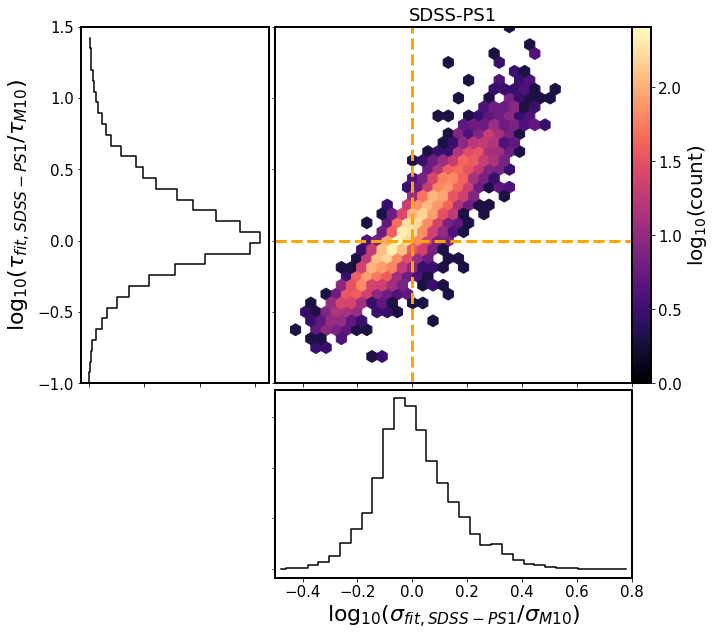

In [286]:
data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
# remove those that according to Chelsea are runaways 

m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 
m = m2&m3&m4
#plot_tau_sigma_ratios(data[m], M10compare=True ,extent=[-.5, .5, -1, 1.2],
##                      rectangle=[-0.45, -0.8, 0.2,0.3], seg='sdss',
#                     )
plot_tau_sigma_ratios(data[m], M10compare=True ,extent=[-.5, .8, -1, 1.5],
                      seg='sdss-ps1',
                     )

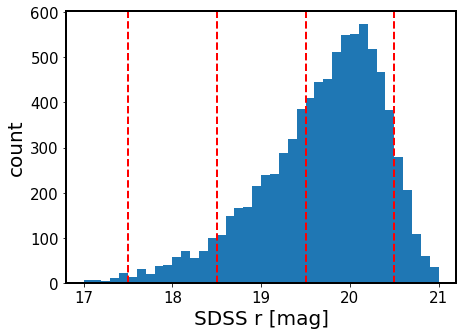

In [97]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.hist(data['r'].data, bins=40, range=(17,21))
rbins = np.arange(17.5, 21, 1)
for rbin in rbins : 
    ax.axvline(rbin, ls='--', lw=2, c='r')
ax.set_xlabel('SDSS r [mag]')
ax.set_ylabel('count')
plt.savefig('SDSS_QSO_r_band_dist.png', bbox_inches='tight', dpi=100)

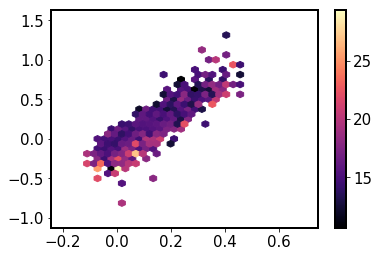

In [191]:
fig,ax1 = plt.subplots(1,1)

#data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
 #                 format='ascii')

#m = (data['r'].data > 20 ) & (data['r'].data < 22)
x = np.log10(data['sigmaEXP_sdss-ps1'][m] / data['sigmaEXP_sdss'][m] )
y = np.log10(data['tauEXP_sdss-ps1'][m]  / data['tauEXP_sdss'][m] )
z = data['N_PS1_raw'][m].data


extent = [-0.2, 0.7, -1., 1.5 ]

xmin,xmax = extent[0], extent[1]
ymin,ymax = extent[2], extent[3]

# main axis : the hexbin 
#ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
#ax1.xaxis.set_major_formatter(plt.NullFormatter())
#ax1.yaxis.set_major_formatter(plt.NullFormatter())
image = ax1.hexbin(x, y, z , extent = extent, gridsize=35, 
      mincnt=1, cmap='magma')
plt.colorbar(image)

Try to see if perhaps there is any distribution in N pts... 

(array([0.00020461, 0.0002224 , 0.00059603, 0.00644954, 0.04141046,
        0.023503  , 0.00052486, 0.00071167, 0.00114757, 0.00098745]),
 array([  5. ,  18.2,  31.4,  44.6,  57.8,  71. ,  84.2,  97.4, 110.6,
        123.8, 137. ]),
 <a list of 1 Patch objects>)

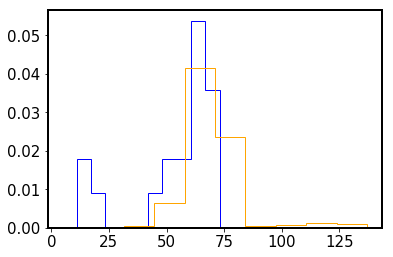

In [209]:
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'] )
y = np.log10(data['tauEXP_sdss-ps1']/ data['tauEXP_sdss'])
z = data['N_SDSS_clean'].data  + data['N_PS1_clean'].data

m_ratio = (y>1) & (x>0.5)

fig,ax = plt.subplots(1,1)
#ax.hist(z, histtype='step',color='orange')
ax.hist(z[m_ratio],histtype='step', color='blue', density='True')
ax.hist(z, histtype='step',color='orange',density='True')

Do the r-mag bins :" "

17.5 18.5
492  of  492
Saved as  Compare_Celerite_tau_sigma_ratios_r_17.5-18.5.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:87: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


18.5 19.5
2275  of  2275
Saved as  Compare_Celerite_tau_sigma_ratios_r_18.5-19.5.png
19.5 20.5
4861  of  4861
Saved as  Compare_Celerite_tau_sigma_ratios_r_19.5-20.5.png


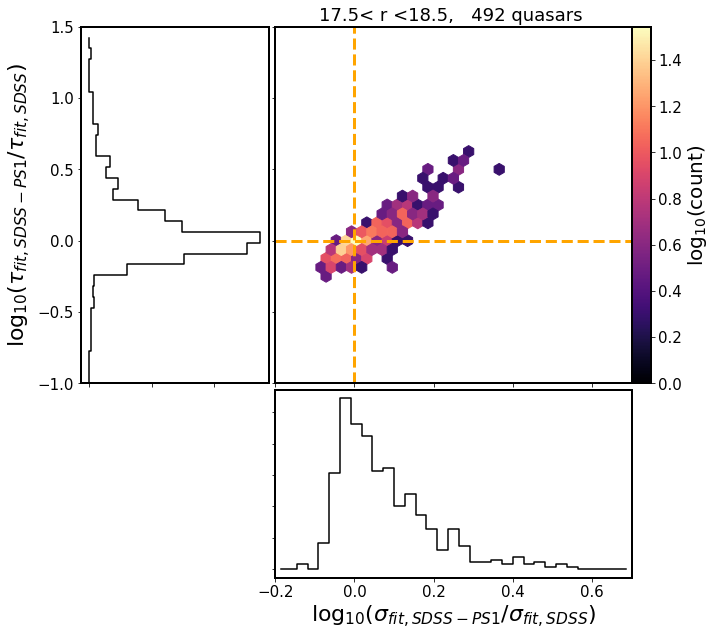

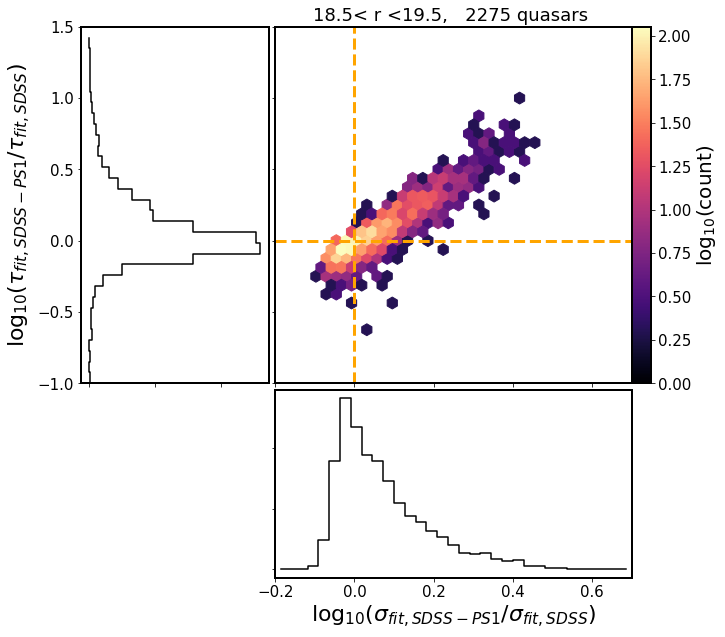

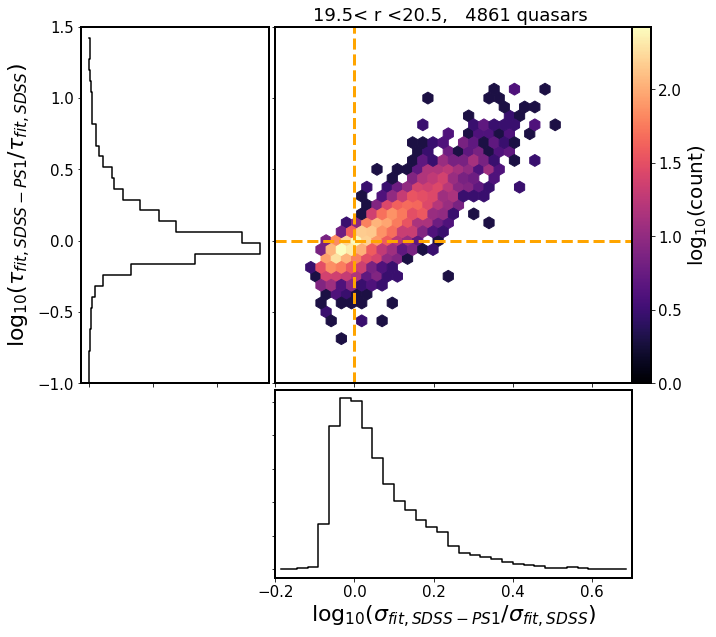

In [93]:
# use the celerite results cross-matched 
# 
data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')

# let's plot that in bins of r-mag ...
for i in range(len(rbins)-1):
#i=0
    rmin = rbins[i] ; rmax = rbins[i+1]
    print(rmin, rmax )
    m = (rmin < data['r'].data ) & ( data['r'].data < rmax)
    app = str(rmin)+'-'+str(rmax)+'.png'
    plot_tau_sigma_ratios(data[m],
                          figname = 'Compare_Celerite_tau_sigma_ratios_r_' + app ,
                          figtitle = str(rmin)+'< r <'+str(rmax)+  ',   ' +\
                                     str(np.sum(m)) + ' quasars '
                         )

Plot in $K-\hat{\sigma}$ space  : 

In [10]:
data[:4]

<Table length=4>
   lcname      length_sdss     ...  tauEXP_sdss-ps1    tauMAP_sdss-ps1  
   str11         float64       ...      float64            float64      
----------- ------------------ ... ------------------ ------------------
1000679.txt 3336.9561299999987 ... 167.45543385469037  105.7514695004934
1000743.txt  3336.956146000004 ...  64.69659233082916  38.02466436230678
1001265.txt 3327.0175859999945 ...  2176.490232313127 1173.7370179688864
1001294.txt 2582.9626130000033 ...  584.5346281760777  68.96318801720331

In [14]:
import matplotlib.patches as patches
import matplotlib as mpl

def plot_K_sigma_hat(data, extent=None, rectangle = None,
                    figname = None, figtitle = None):
    ''' A convenience function to plot 
    the changes in DRW parameters between SDSS and SDSS-PS1 
    when using Celerite  in K-sigmahat space 
    (rather than tau-sigma)
    

    rectangle = [x0,y0, width,height ] adds a red rectangle to 
    mark a given region if needed.

    
    '''
    fig = plt.figure(figsize=(9, 9))

    # an obvious cut, if nothing more stringent needed ... 
    m= data['tauMAP_sdss-ps1'] > 0 
    print(np.sum(m), ' of ', len(m))
    
    sigma1 = data['sigmaEXP_sdss-ps1'].data
    sigma2 = data['sigmaEXP_sdss'].data
    tau1 = data['tauEXP_sdss-ps1'].data
    tau2 = data['tauEXP_sdss'].data 
    
    sigma_hat_12 = (sigma1/sigma2) * np.sqrt(tau2/tau1)
    K_12 = (tau1/tau2) * np.sqrt(sigma1/sigma2)
    
    x = np.log10(sigma_hat_12)
    y = np.log10(K_12)
    
    if not extent : 
        extent = [-0.2, 0.7, -1., 1.5 ]

    xmin,xmax = extent[0], extent[1]
    ymin,ymax = extent[2], extent[3]

    # main axis : the hexbin 
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    image = ax1.hexbin(x, y, extent = extent, gridsize=35, 
          bins='log', vmin=1 , mincnt=2, cmap='magma')

    # add colorbar ... 
    vmin, vmax = image.get_clim()
    norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
    cmap.set_array([])
    left, bottom, width, height = 0.95, 0.4, 0.03, 0.55
    cax = fig.add_axes([left,bottom,width,height])
    plt.colorbar(mappable = cmap, cax = cax, orientation='vertical',
                label=r'$\log_{10}{(\mathrm{count})}$')
    ls='--'; lw = 3 ;c='orange'
    ax1.axvline(0,ls=ls,lw=lw,c=c)
    ax1.axhline(0,ls=ls,lw=lw,c=c)
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
    
    
    #xmin,xmax = ax1.get_xlim()
    #xx  = np.linspace(xmin,xmax)
    #ax1.plot(xx,ls='--',lw=3,c='r')

    # second axis, marginalizing along x 
    left, bottom, width, height = 0.1, 0.4, 0.29, 0.55
    ax2 = fig.add_axes((left, bottom, width, height))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    hist_y, bins_y = np.histogram(y, bins=33, normed=True, range=extent[2:])
    ax2.plot(hist_y, 0.5 * (bins_y[1:] + bins_y[:-1] - bins_y[1] + bins_y[0]),
             '-k', drawstyle='steps')
    ax2.set_ylim(ymin,ymax)

    # third axis, marginalizing along y 
    # third axis: marginalized over gamma
    left, bottom, width, height = 0.4, 0.1, 0.55, 0.29
    ax3 = fig.add_axes((left, bottom, width, height))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    hist_x, bins_x = np.histogram(x, bins=33, normed=True, range=extent[:2])
    ax3.plot(0.5 * (bins_x[1:] + bins_x[:-1]), hist_x,
             '-k', drawstyle='steps-mid')
    ax3.set_xlim(xmin,xmax)
    
    if rectangle  : 
        # add a red rectangle ..
        x0, y0, w, h = rectangle
        rect = patches.Rectangle((x0,y0),w,h, linewidth=1,
                                 edgecolor='r',facecolor='red', alpha=0.5)
        # Add the patch to the Axes
        ax1.add_patch(rect)

    # axis title, labels   ....
    string = r'$\log_{10}{\left( \hat{\sigma}_{fit, %s} / \hat{\sigma}_{fit,%s} \right)}$'%\
    ('SDSS-PS1','SDSS')
    ax3.set_xlabel(string, fontsize=22)

    ax2.set_ylabel(r'$\log_{10}{\left( \mathrm{K}_{fit,SDSS-PS1} / \mathrm{K}_{fit,SDSS}\right)}$',
              fontsize=22)
    if  not figname : 
        figname = 'Compare_Celerite_SDSS-PS1_vs_SDSS_EXP_K-sigma-hat_'+fname[:6]+'.png'

    ax1.set_title(figtitle, )
    
    print('Saved as ',  figname)
    plt.savefig(figname,  
                bbox_inches='tight', dpi=100)

8516  of  8516
Saved as  Compare_Celerite_SDSS-PS1_vs_SDSS_EXP_K-sigma-hat_190606.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


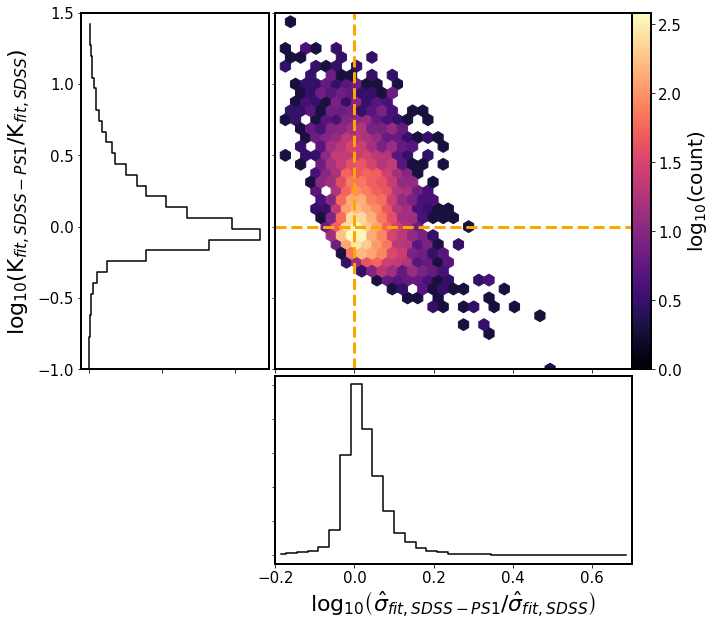

In [16]:
fname = '190606_Celerite_real_Jeff1.txt'
data =  Table.read(fname, format='ascii')


8516  of  8516
Saved as  Compare_Celerite_SDSS-PS1_vs_SDSS_EXP_K-sigma-hat_190606.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


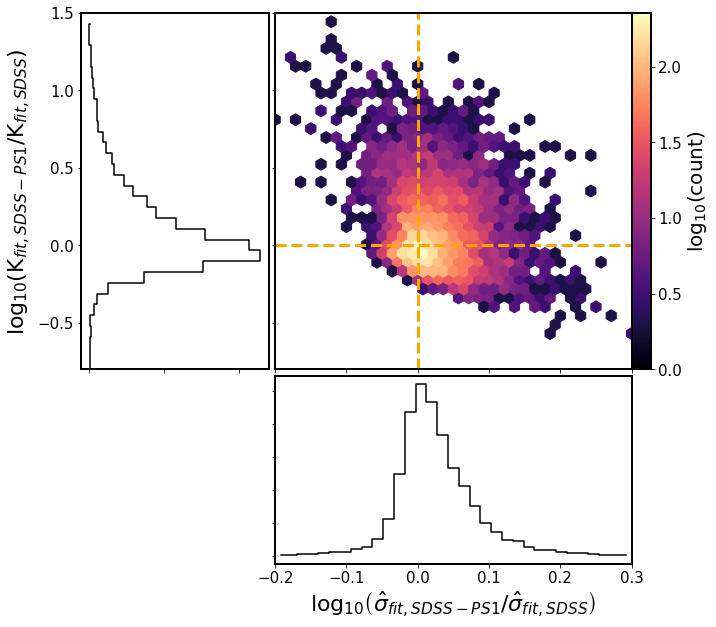

In [23]:
plot_K_sigma_hat(data, extent = [-.2, .3, -.8, 1.5 ])

In [3]:
from astropy.table import Table
data = Table.read('190606_Celerite_real_Jeff1.txt', format='ascii')
data

<Table length=8516>
   lcname      length_sdss     ...  tauEXP_sdss-ps1    tauMAP_sdss-ps1  
   str11         float64       ...      float64            float64      
----------- ------------------ ... ------------------ ------------------
1000679.txt 3336.9561299999987 ... 167.45543385469037  105.7514695004934
1000743.txt  3336.956146000004 ...  64.69659233082916  38.02466436230678
1001265.txt 3327.0175859999945 ...  2176.490232313127 1173.7370179688864
1001294.txt 2582.9626130000033 ...  584.5346281760777  68.96318801720331
1001531.txt  3336.956121999996 ... 1144.9618455280802   413.609460590005
1001793.txt  3336.956118000002 ...  847.3215328837978 398.54346141818365
1002076.txt 3336.9563599999965 ...  945.0038087595027   436.536918133285
1002162.txt 3321.0338460000057 ... 218.73857772282028 127.55064253761121
1002453.txt  3321.033841999997 ...  746.9951815218747 375.36677476619633
 100286.txt  3336.933284999999 ...  739.6180749274157  221.9785804405557
        ...                ... ...                ...                ...
 997798.txt 3336.9561269999977 ...  965.7707306096497  477.2978356844034
 998022.txt 3336.9561659999963 ...  2670.888234503446 1855.0062643108506
 998340.txt  3321.034075000003 ... 222.26007740771124 104.31160866439835
 998548.txt 3321.0338209999973 ...  2083.679148877401 1213.0554648323514
 998768.txt  3336.956116000001 ... 1691.9078036266012  818.4411906003238
 998917.txt 3336.9561220000032 ... 1059.6518516436163  529.0796400971716
 998945.txt 3330.9723950000043 ... 395.51834310968366 215.93715654837231
 999131.txt  2571.970337000006 ...  610.4854524128972  323.5343175935688
 999464.txt  3316.025228999999 ...  2442.898545576377 1545.4419762950447
 999508.txt 3336.9561539999995 ...  932.7639483941541  493.2437042749212

Select some light curves with smallest $\tau$ ratios and largest $\sigma$ ratios 

In [100]:
#data = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
#data = Table.read('190409_Celerite_real_Jeff1.txt', format='ascii')
data = Table.read('190606_Celerite_real_Jeff1.txt', format='ascii')
# m2 = data['Plike'] - data['Pnoise'] > 2 
# m3 = data['Plike'] - data['Pinf'] > 0.05 
# m4 = data['edge'] == 0 
# m_sel = m2&m3&m4

x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])

m_ratio = (y>1) & (x>0.4)

#m = m_sel & m_ratio
m  =  m_ratio
data[m_ratio]

<Table length=44>
   lcname      length_sdss     ...  tauEXP_sdss-ps1     tauMAP_sdss-ps1  
   str11         float64       ...      float64             float64      
----------- ------------------ ... ------------------ -------------------
1003694.txt 3321.0338459999984 ...  1492.163497343035   792.9020598108034
1124333.txt  2934.938688000002 ...  600.6115083994748   269.3910895400171
 123909.txt 3321.0339959999983 ...  2128.709898573251  1112.0823342299614
1299803.txt 3321.0338439999978 ... 1996.8901843096437  1088.4446230847145
1378415.txt 2947.9454909999986 ...   1532.42766438455   760.8197699226507
1412379.txt 2934.9386899999954 ... 1711.3004719475791   838.2908398448943
1446022.txt  2934.938734000003 ...   452.107376805033   189.7722065273855
1644710.txt 3336.9561269999977 ...  923.6463242828372  424.10995182832215
1730482.txt 3336.9561290000056 ...  399.6632670535442  234.74972380635253
1788562.txt 2934.9386470000027 ...   671.099161672324  234.76358880348693
        ...                ... ...                ...                 ...
3976336.txt 3321.0338889999985 ...   1544.72336816239   658.5456104211646
4069419.txt 3321.0339160000003 ... 1723.8964371132417   748.3396906883377
4205621.txt  2229.947137999996 ...  2076.377003667851   906.0101455842413
 467617.txt  2934.938753000002 ... 1602.8400465340742   761.6299848399842
4913626.txt        2593.986481 ...  2383.105725122537   1401.470799445947
4950664.txt  3310.041465000002 ... 2189.9694618207777   1108.563261942956
 568312.txt 3336.9333879999976 ... 1737.5770370954024   869.1317668882775
 612585.txt 3336.9332820000054 ...  872.3111085984715  345.06204031018166
 751557.txt  332.0341600000029 ...  306.6854273674961 0.09999999999999998
   8442.txt  3336.933327999999 ... 1904.6284726301417   896.4815595075577

For these now I want three panels, showing :
* SDSS r-band + PS1 DR1 gri  turned into SDSS r ('../dp2/real_combined_r/')
* SDSS r-band + PS1 DR1 r (raw ) ('../dp2/real_outer_join/')
* SDSS r-band + PS1 DR2 r (raw )  ('../dp2/real_sdss_ps1r_dr2_cleaned/')

For the top and bottom, which have been fitted with Celerite, show $\tau$ and $\sigma$
* `190409_Celerite_real_Jeff1.txt` for top (SDSS r-band + PS1 DR1 gri turned r ) 
* `190606_Celerite_real_Jeff1.txt` for bottom (SDSS r-band + PS1 DR2 r raw no offset )

In [254]:
botRes[:4]

<Table length=4>
 lcname     length_sdss     ...        SFinf             lambdaRF     
 str11        float64       ...       float64            float64      
-------- ------------------ ... ------------------- ------------------
  70.txt 3336.9332799999975 ... 0.09622425731393176  3014.954172696575
  98.txt  2582.962741999996 ... 0.23211252059810764 3498.0690658756366
 233.txt 3321.0338420000044 ... 0.12325897950662115  2385.587236154052
1018.txt 3336.9333019999976 ... 0.33696948003053717  3875.968992248062

In [256]:
botRes = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii') 
botRes['tauM10'] =  np.power(10, botRes['log10tau']) 
botRes['sigmaM10'] =    botRes['SFinf'] / np.sqrt(2)     
botRes[m]['sigmaEXP_sdss','sigmaEXP_sdss-ps1', 'sigmaM10', 'tauEXP_sdss', 
          'tauEXP_sdss-ps1','tauM10']

<Table length=69>
   sigmaEXP_sdss     sigmaEXP_sdss-ps1  ...       tauM10      
      float64             float64       ...      float64      
------------------- ------------------- ... ------------------
0.14293114772737148  0.2170235557337519 ...  4838.825938327178
0.21910358134070673 0.22127047648550216 ... 7159.7853108196205
0.09218129059530113 0.09905035670146689 ...  6100.283239357591
 0.0834365533765686 0.20752258263049803 ...  3307.196502509928
0.14189165971118714 0.15460648872232996 ...  5103.992176283075
0.21271436803201776 0.19735576153919926 ...  6325.283566745532
0.36202049704499767 0.39953889093370737 ...  7019.885039427151
0.10713462627140735 0.12143955654555483 ...  6625.062809560889
 0.3036404582302422  0.3333222817735906 ...   4980.92497228274
 0.1696233072707608 0.17439615430749328 ...  5297.122299443125
                ...                 ... ...                ...
0.12205089694118115  0.1470286187154224 ...  4347.704312120325
0.11875237487500165 0.10477763100243837 ...  5251.338334273915
0.25141192714082294 0.26531194980357214 ...  8104.197196287525
0.17694039711479567 0.22887741072465437 ...  6857.723964327918
0.16816670295598843 0.20358176012752172 ...  6306.087608920976
0.17135312107331388  0.1694272923832694 ... 6878.5991230880745
0.12134006552126922  0.1403664198848179 ...  4427.616528308719
0.13877754060788797 0.16037631077211667 ... 2194.7749765574576
0.12933691538914685 0.23241914707884204 ...  5156.915319295977
0.14117675583107206 0.17388175891720964 ...  10366.44863184039

In [7]:
%matplotlib inline

#lcnames = data[m_ratio]['lcname'].data

# SDSS r-band,  and PS1 DR1 gri  --> synthetic r ... 
topRes = Table.read('190409_Celerite_real_Jeff1.txt', format='ascii')

# SDSS r-band,  and PS1 DR2 r, no offset 
botRes = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii') 
botRes['tauM10'] =  np.power(10, botRes['log10tau']) 
botRes['sigmaM10'] =    botRes['SFinf'] / np.sqrt(2)     
#Table.read('190606_Celerite_real_Jeff1.txt', format='ascii')


def plot_SDSS_PS1_lc(lcname, topRes=topRes,botRes=botRes):
    
    topDir = '../dp2/real_combined_r/' # with offsets to SDSS r 
    midDir = '../dp2/real_outer_join/' # without offsets  - just raw 
    botDir = '../dp2/real_sdss_ps1r_dr2/' # without offsets, DR2
    botDircleaned = '../dp2/real_sdss_ps1r_dr2_cleaned/' # without offsets, DR2 clean
    
    fig,ax = plt.subplots(4,1,figsize=(9,19))

    ################################################
    # top SDSS r-band + PS1 DR1 gri  turned into SDSS r  
    ################################################
    # get the lightcurve
    lc = Table.read(topDir+lcname, format='ascii')

    # plot the observed signal 
    rows = lc['originSurvey'] == 'sdss'
    ax[0].errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                    fmt=".", capsize=0.2, label='SDSS r',
                    c ='blue')
    
    colors = ['seagreen', 'red', 'darkturquoise']
    j = 0 
    for f in 'gri':
        rows = (lc['originSurvey'] == 'ps1')&(lc['originBand'] == f)
        ax[0].errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                    fmt=".", capsize=0.2, label='PS1 DR1 '+f,
                    c =colors[j])
        j +=1 

    # add legend 
    ax[0].legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )#, loc='upper right')

    # place a text box with fit results
    # get the fit results 
    mrow =  topRes['lcname'] == lcname
    selected = topRes[mrow]
    
    textstr = '\n'.join((
        r'$\tau_{\mathrm{SDSS}}=%.4f$' % (selected['tauEXP_sdss'], ),
        r'$\tau_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['tauEXP_sdss-ps1'],),
        r'$\sigma_{\mathrm{SDSS}}=%.4f$' % (selected['sigmaEXP_sdss'], ),
        r'$\sigma_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['sigmaEXP_sdss-ps1'], ),
                        ))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax[0].text(1.05, 0.5, textstr, transform=ax[0].transAxes, fontsize=16,
            verticalalignment='top', bbox=props)

    # axis props 
    ax[0].set_title('dbID '+lcname[:-4])
    xlims = np.array(ax[0].get_xlim())

    ################################################
    # middle  : SDSS r-band and raw PS1 DR1 r-band 
    ################################################
    # get the lightcurve
    lc = Table.read(midDir+lcname, format='ascii')

    use_segments = 'sdss,ps1'
    colors = ['blue','red']
    labels = ['SDSS r', 'PS1 DR1 r ']
    
    j = 0
    for s in use_segments.split(','):
        rows = (lc['survey'] == s) & (lc['filter']  == 'r')
        # plot the "observed" lc 
        ax[1].errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                    fmt=".", capsize=0.2, label=labels[j],
                    c = colors[j])
        j += 1 

    # add legend 
    ax[1].legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )#, loc='upper right')  
    
    xlims = np.append(xlims, ax[1].get_xlim())
    
    ################################################
    # bottom  : SDSS r-band and PS1 DR2 r-band raw 
    ################################################
    # get the lightcurve
    lc = Table.read(botDir+lcname, format='ascii')

    j=0
    labels = ['SDSS r', 'PS1 DR2 r']
    for s in use_segments.split(','):
        rows = lc['survey'] == s 
        # plot the "observed" lc 
        ax[2].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                     lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                   c = colors[j])
        j += 1 
        
    # code for flaggng 5 sigma  from  AC_combined_LC.ipynb . 
    # do that for the entire LC, including SDSS and PS1 parts 
    # together ... 
    Nsig = 5 
    #rows = lc['survey'] == 'ps1' 
    sigmaGmag =  0.7413 * (np.percentile(lc['mag'],75) -\
                        np.percentile(lc['mag'],25))
    msig = np.abs(np.ma.median(lc['mag']) - lc['mag']) > Nsig *sigmaGmag

    ax[2].scatter(lc['mjd'][msig], lc['mag'][msig],
               s=120, facecolors='none', edgecolors='g', 
                  label=str(Nsig)+r'$\sigma$ mag')
    
    # also, flag the SDSS or PS1 points that have an error over 5 times that 
    # of the sigmaG of the errors for the entire  light curve ...
    # SDSS and PS1 points are similar enough to be considered together
    # - remove points with way larger error than the rest 
    sigmaGerr =  0.7413 * (np.percentile(lc['magerr'],75) -\
                         np.percentile(lc['magerr'],25))
    merr = np.abs(np.ma.median(lc['magerr']) -  lc['magerr'])   > Nsig *  sigmaGerr
    
    ax[2].scatter(lc['mjd'][merr], lc['mag'][merr],
               s=80, facecolors='none', edgecolors='magenta', 
                  label=str(Nsig)+r'$\sigma$ err')
    
    # add legend 
    ax[2].legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )#, loc='upper right')

    
    # place a text box with Chelsea's fit results
    # get the fit results 
    mrow =  botRes['lcname'] == lcname
    selected = botRes[mrow]
    
    textstr = '\n'.join((
        r'$\tau_{\mathrm{M10,SDSS}}=%.4f$' % (selected['tauM10'], ),
        r'$\sigma_{\mathrm{M10,SDSS}}=%.4f$' % (selected['sigmaM10'])
      ))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax[2].text(1.05, 0.47, textstr, transform=ax[2].transAxes, fontsize=16,
            verticalalignment='top', bbox=props)

    
    # axis props 
    #ax[2].set_title('dbID '+lcname[:-4])
    xlims = np.append(xlims, ax[2].get_xlim())
    

    ### final :  plot updated DR2 : does day-averaging and sigma clipping 
    # fix the data issues  ? 
    
    # the resulting light curves were stored in a new dir : 
    botDircleaning = '../dp2/real_sdss_ps1r_dr2_cleaning/'
    # has all the intermediate data products : 
    # mjd, mag,  magerr, Nobs,  avgmag,  medmag,  avgerr 
    lc = Table.read(botDircleaning+lcname, format='ascii')
    
    
    # plot what eventually would be used  : the 
    # sdss, ps1 days with single obs 
    
    colors = ['blue','red']
    labels = ['SDSS r', 'PS1 DR2 r']
    j = 0 
    for s in use_segments.split(','):
        rows = (lc['survey'] == s ) & (lc['Nobs'] == 1 )
        ax[3].errorbar(lc['mjd'][rows], lc['mag'][rows], 
                 lc['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
               c = colors[j])
        j += 1 

    # and with a different color : avg mag  and median mag ,
    # to show the difference
    lc1 = unique(lc[lc['Nobs'] > 1], keys='mjdint')

    
     # plot the avg err with avg err 
    ax[3].errorbar(lc1['mjd'], lc1['avgmag'], lc1['avgerr'], 
                   fmt="h", capsize=0.2, markersize=10, label='weighted average',
               c = 'mediumaquamarine')
    
    
    # plot the median mag with avg err
    ax[3].errorbar(lc1['mjd'], lc1['medmag'], lc1['avgerr'], 
                   fmt=".", capsize=0.2, markersize=10, label='median',
               c = 'coral')

    ax[3].legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )

    
    # place a text box with results
    mrow =  botRes['lcname'] == lcname
    selected = botRes[mrow]
    
    textstr = '\n'.join((
        r'$\tau_{\mathrm{SDSS}}=%.4f$' % (selected['tauEXP_sdss'], ),
        r'$\tau_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['tauEXP_sdss-ps1'],),
        r'$\sigma_{\mathrm{SDSS}}=%.4f$' % (selected['sigmaEXP_sdss'], ),
        r'$\sigma_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['sigmaEXP_sdss-ps1'], ),
                        ))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax[3].text(1.05, 0.5, textstr, transform=ax[3].transAxes, fontsize=16,
            verticalalignment='top', bbox=props)

    xmin,xmax = min(xlims), max(xlims)

    for i in range(len(ax)):
        ax[i].set_xlim(xmin,xmax)
        ax[i].grid()
        ax[i].invert_yaxis()
        ax[i].set_xlabel('mjd')
        ax[i].set_ylabel('mag')
    figname = 'SDSS_PS1_comp_DR1_DR2_'+lcname[:-4]+'.png'

    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)
    
    return lc 

Check LCs where ratio of Celerite SDSS to Chelsea SDSS is very off ... 

69 / 8516
Saved as  SDSS_PS1_comp_DR1_DR2_44039.png
Saved as  SDSS_PS1_comp_DR1_DR2_109176.png
Saved as  SDSS_PS1_comp_DR1_DR2_223763.png
Saved as  SDSS_PS1_comp_DR1_DR2_256609.png
Saved as  SDSS_PS1_comp_DR1_DR2_331015.png
Saved as  SDSS_PS1_comp_DR1_DR2_331661.png
Saved as  SDSS_PS1_comp_DR1_DR2_349264.png
Saved as  SDSS_PS1_comp_DR1_DR2_385430.png
Saved as  SDSS_PS1_comp_DR1_DR2_448900.png
Saved as  SDSS_PS1_comp_DR1_DR2_521037.png


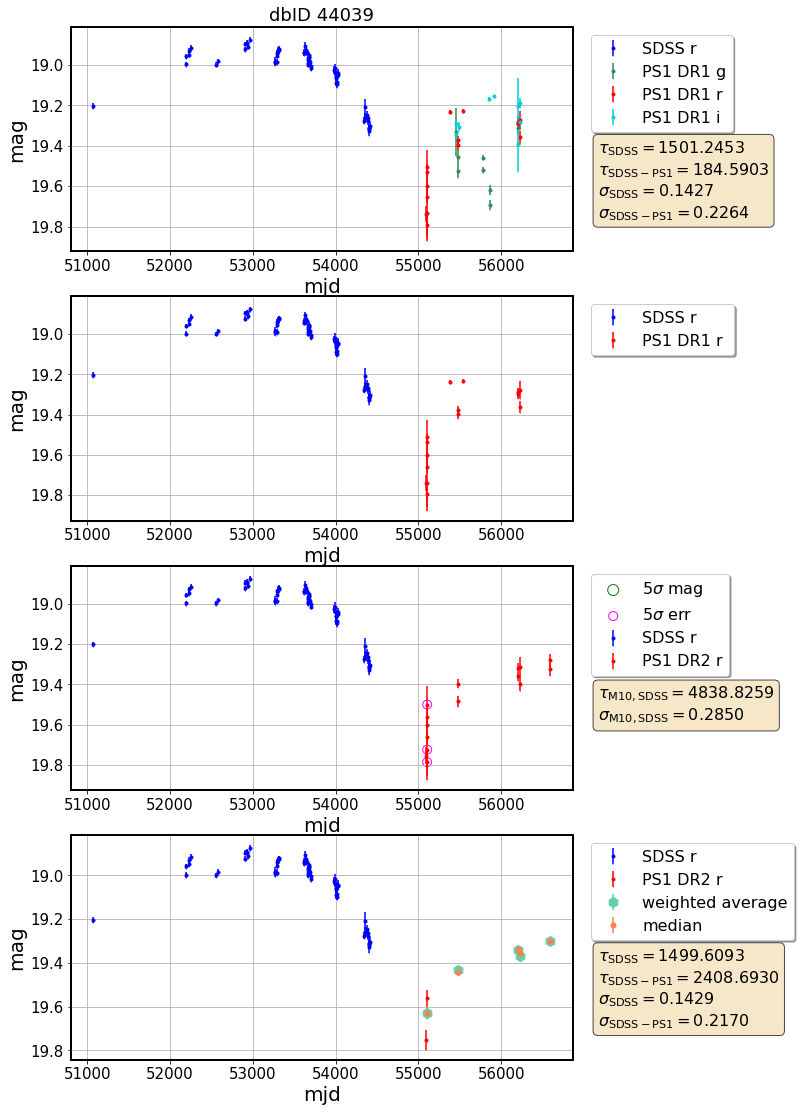

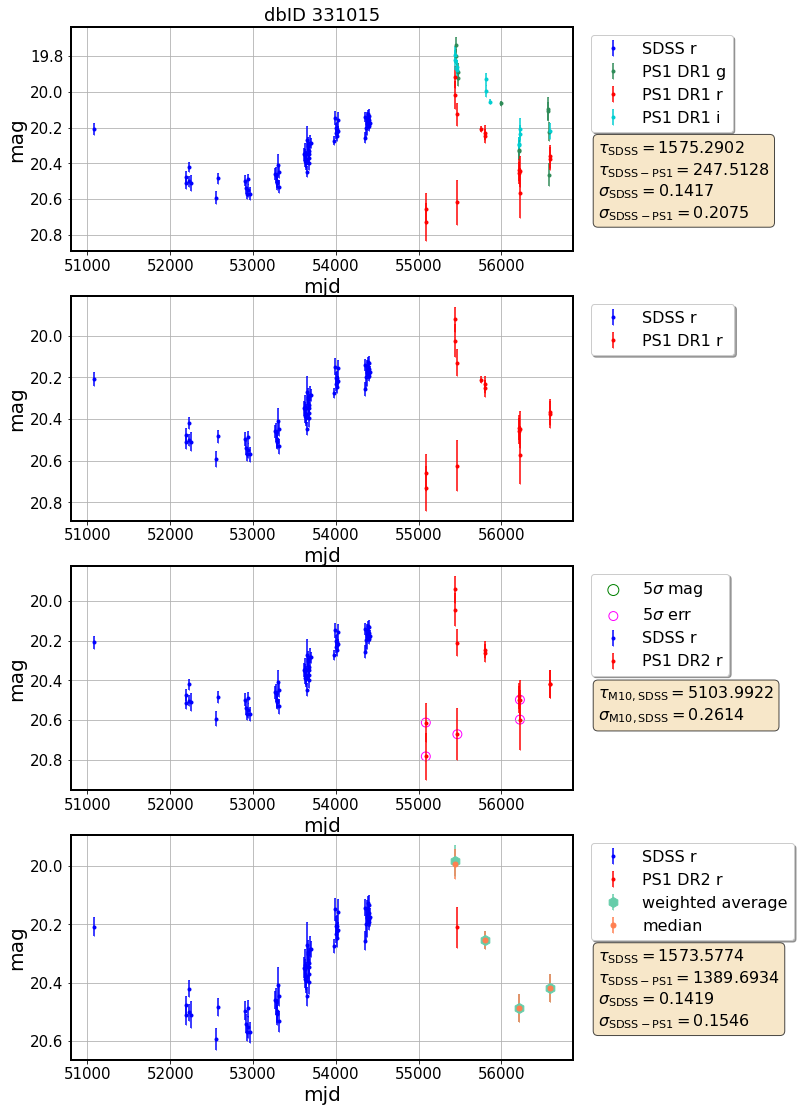

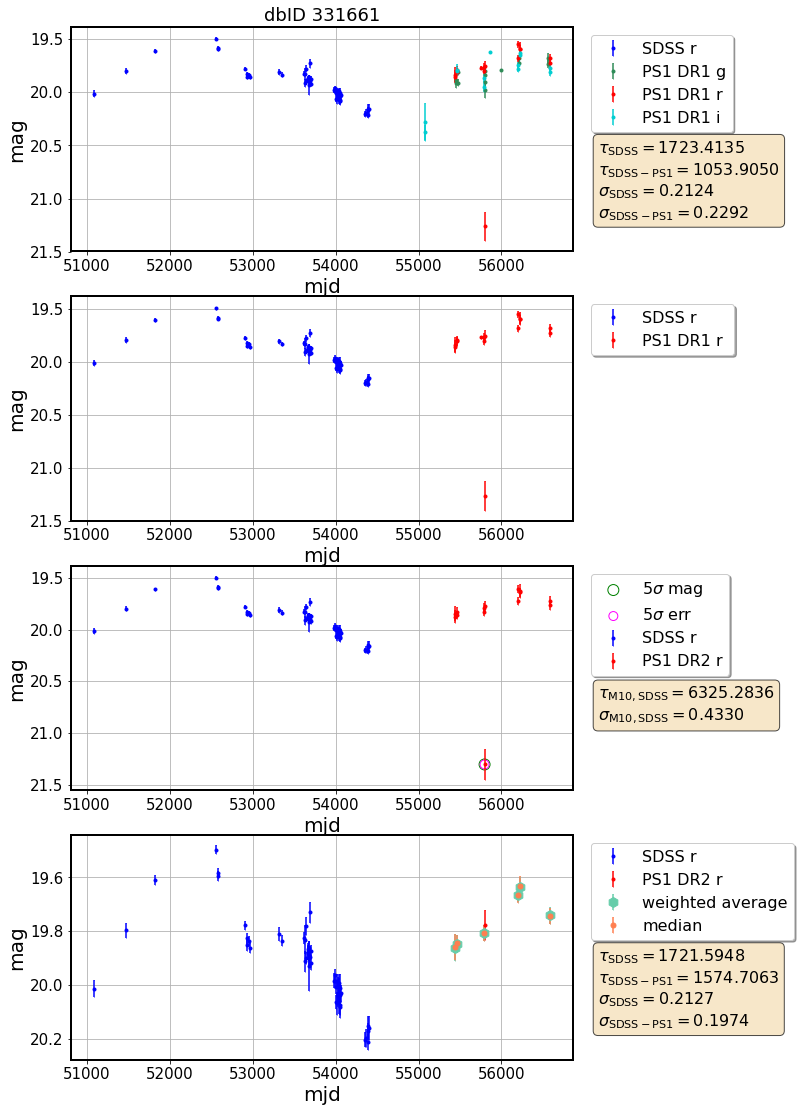

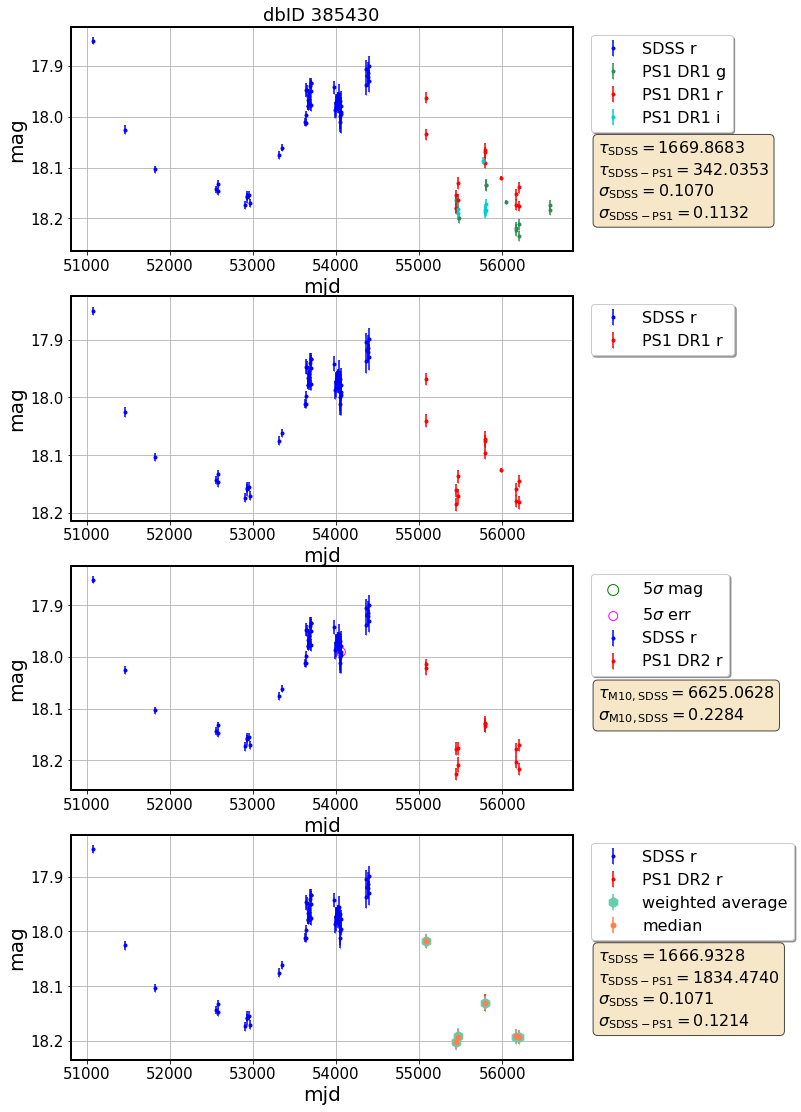

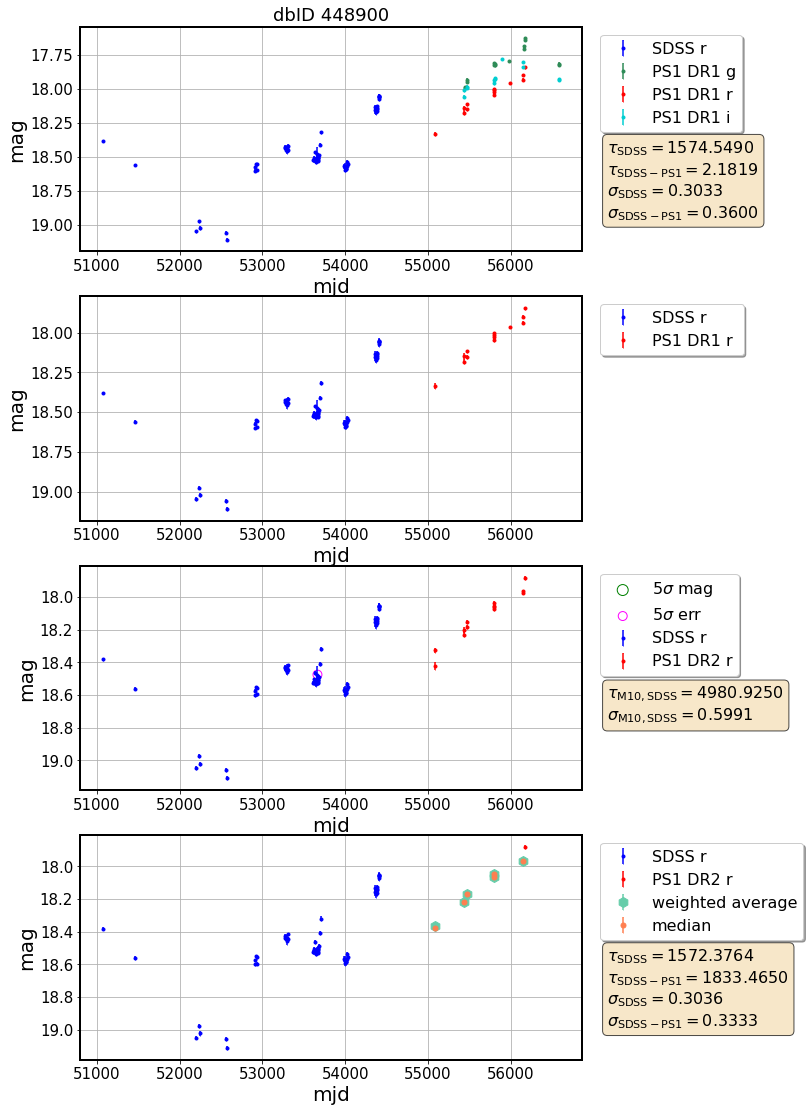

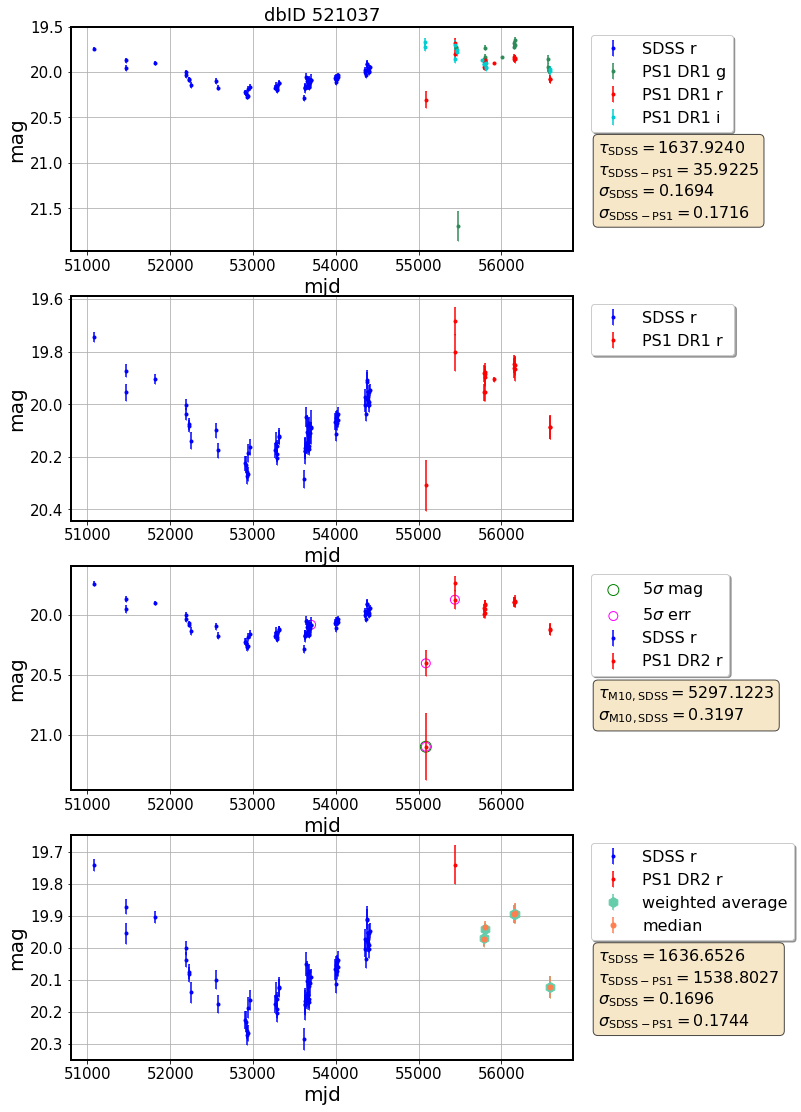

In [265]:
data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
# remove those that according to Chelsea are runaways 
m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 

# select those with low tau ratio and sigma ratio 
seg = 'sdss'
sigCel =  data['sigmaEXP_'+seg]
tauCel =  data['tauEXP_'+seg]
sigM10 =  data['SFinf'] / np.sqrt(2)
tauM10 =  np.power(10, data['log10tau']) 
x  = np.log10(sigCel / sigM10)
y  = np.log10(tauCel / tauM10)

m_x = (-0.45 < x) & (x < -0.25)
m_y = (-0.8 < y) & (y < -0.5)
m_ratio = m_x & m_y 

m = m2&m3&m4&m_ratio
print(np.sum(m),'/',len(m))

lcnames = data[m]['lcname'].data

for lcname in lcnames[:10]:
    lc = plot_SDSS_PS1_lc(lcname)

IndexError: index 0 is out of bounds for axis 0 with size 0

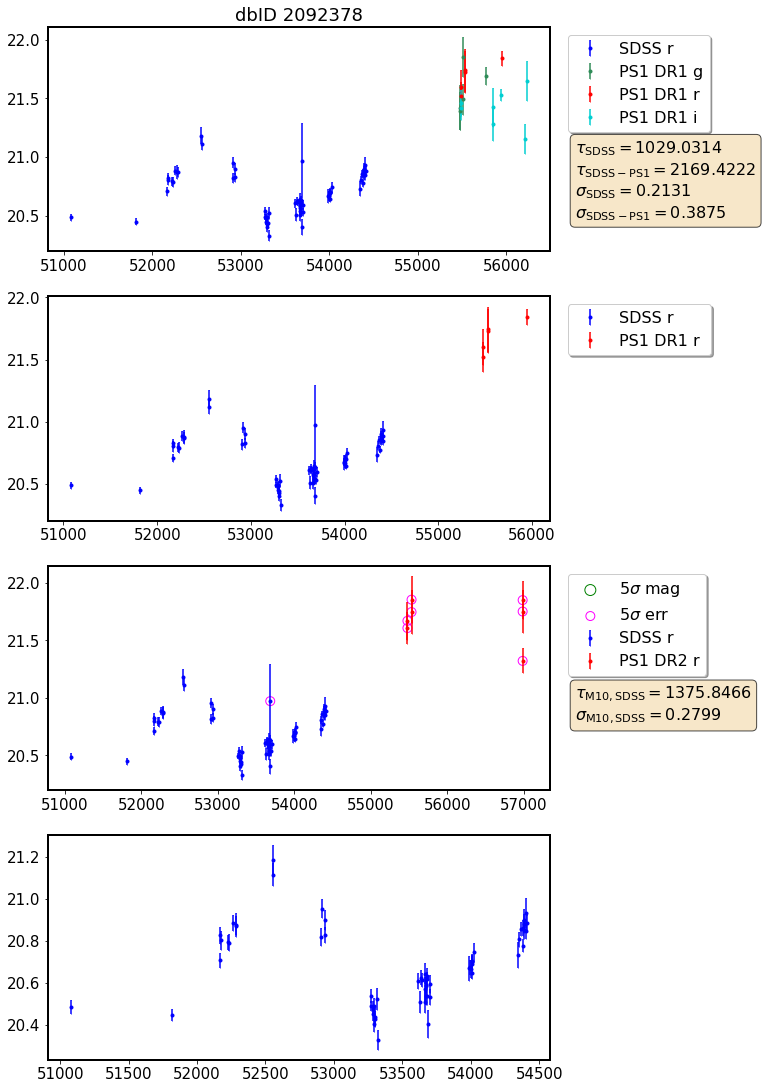

In [8]:
plot_SDSS_PS1_lc('2092378.txt')

(array([1.460e+02, 3.064e+03, 2.059e+03, 7.530e+02, 2.630e+02, 7.500e+01,
        1.900e+01, 8.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.06883876, -0.02785481,  0.01312915,  0.0541131 ,  0.09509705,
         0.13608101,  0.17706496,  0.21804891,  0.25903287,  0.30001682,
         0.34100077]),
 <a list of 10 Patch objects>)

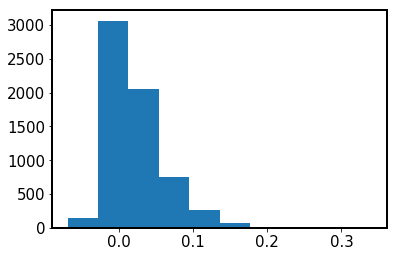

In [274]:
data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
# remove those that according to Chelsea are runaways 
m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 
m = m2&m3&m4
# plot the differences to Chelsea....

sigCel =  data['sigmaEXP_sdss']
tauCel =  data['tauEXP_sdss']
sigM10 =  data['SFinf'] / np.sqrt(2)
tauM10 =  np.power(10, data['log10tau']) 

d1 = sigM10 - data['sigmaEXP_sdss']
d2 = sigM10  - data['sigmaEXP_sdss-ps1']

plt.hist(d1[m]-d2[m])

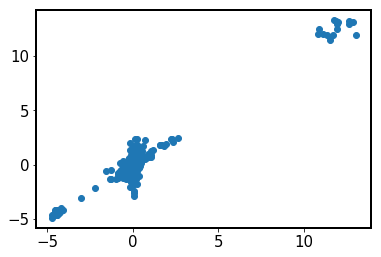

In [284]:
data = Table.read('190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
# remove those that according to Chelsea are runaways 
m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 
m = m2&m3&m4
# plot the differences to Chelsea....

sigCel =  data['sigmaEXP_sdss']
sigM10 =  data['SFinf'] / np.sqrt(2)
tauM10 =  np.power(10, data['log10tau']) 


r1 = np.log10(data['tauEXP_sdss'] / tauM10)
r2 = np.log10(data['tauEXP_sdss-ps1'] / tauM10)

plt.scatter(r1[m],r2[m])
#plt.xlim(-2,2)
#plt.ylim(-2,2)

In [280]:
plt.hist(r2[m]-r1[m])

(array([3.000e+00, 1.000e+00, 7.000e+00, 2.300e+01, 9.900e+01, 4.329e+03,
        1.701e+03, 2.010e+02, 2.200e+01, 3.000e+00]),
 array([-2.9461751 , -2.42519576, -1.90421643, -1.3832371 , -0.86225776,
        -0.34127843,  0.1797009 ,  0.70068024,  1.22165957,  1.7426389 ,
         2.26361824]),
 <a list of 10 Patch objects>)

Examples of LCs where even cleaning didn't prevent problems with the data. 

44
Saved as  SDSS_PS1_comp_DR1_DR2_1003694.png
Saved as  SDSS_PS1_comp_DR1_DR2_1124333.png
Saved as  SDSS_PS1_comp_DR1_DR2_123909.png
Saved as  SDSS_PS1_comp_DR1_DR2_1299803.png
Saved as  SDSS_PS1_comp_DR1_DR2_1378415.png
Saved as  SDSS_PS1_comp_DR1_DR2_1412379.png
Saved as  SDSS_PS1_comp_DR1_DR2_1446022.png
Saved as  SDSS_PS1_comp_DR1_DR2_1644710.png
Saved as  SDSS_PS1_comp_DR1_DR2_1730482.png
Saved as  SDSS_PS1_comp_DR1_DR2_1788562.png


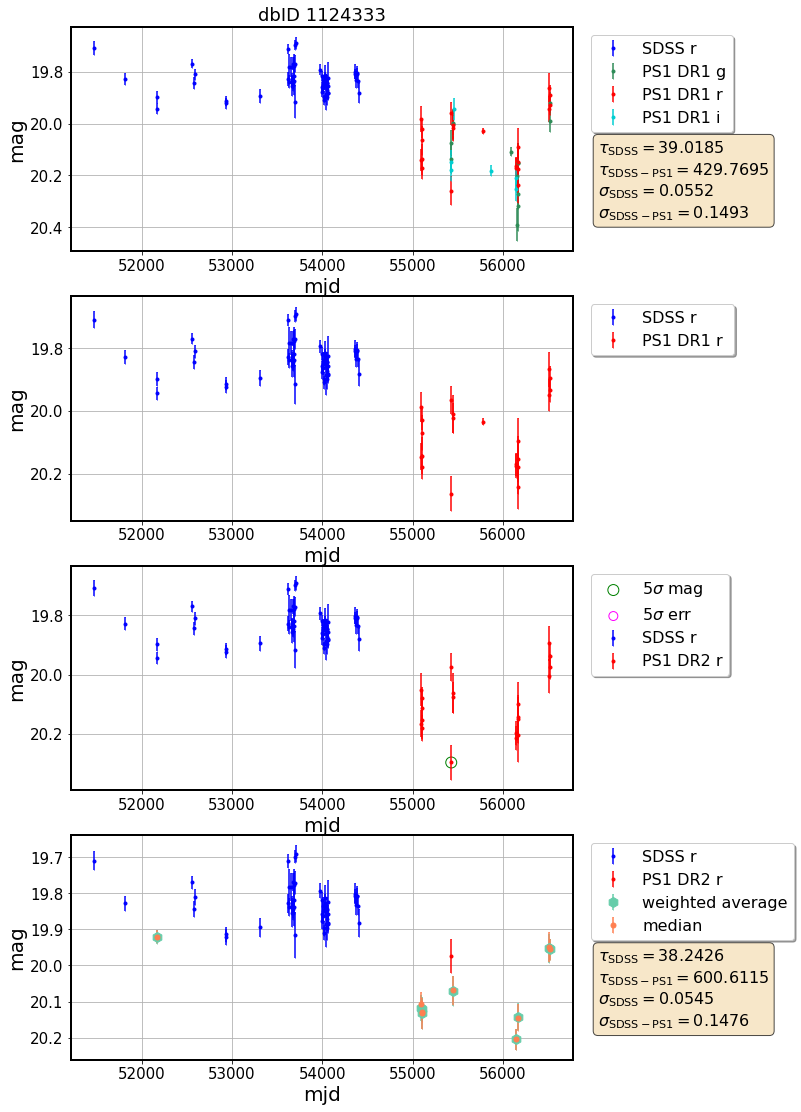

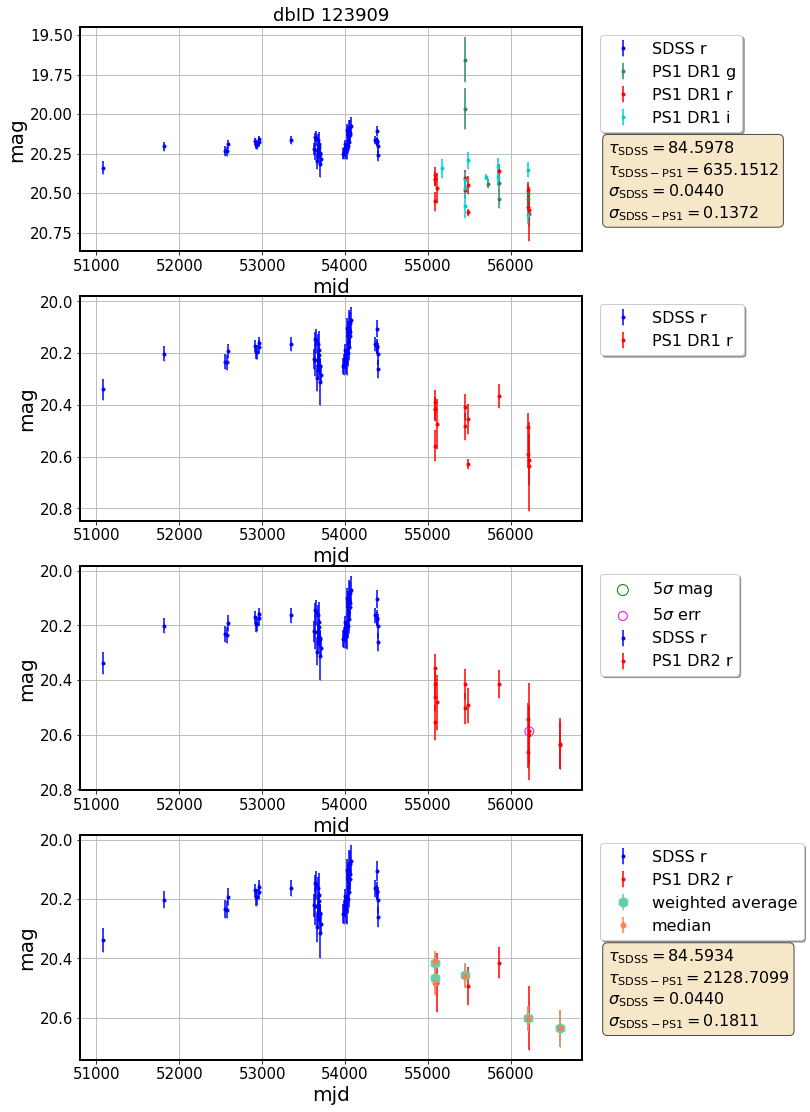

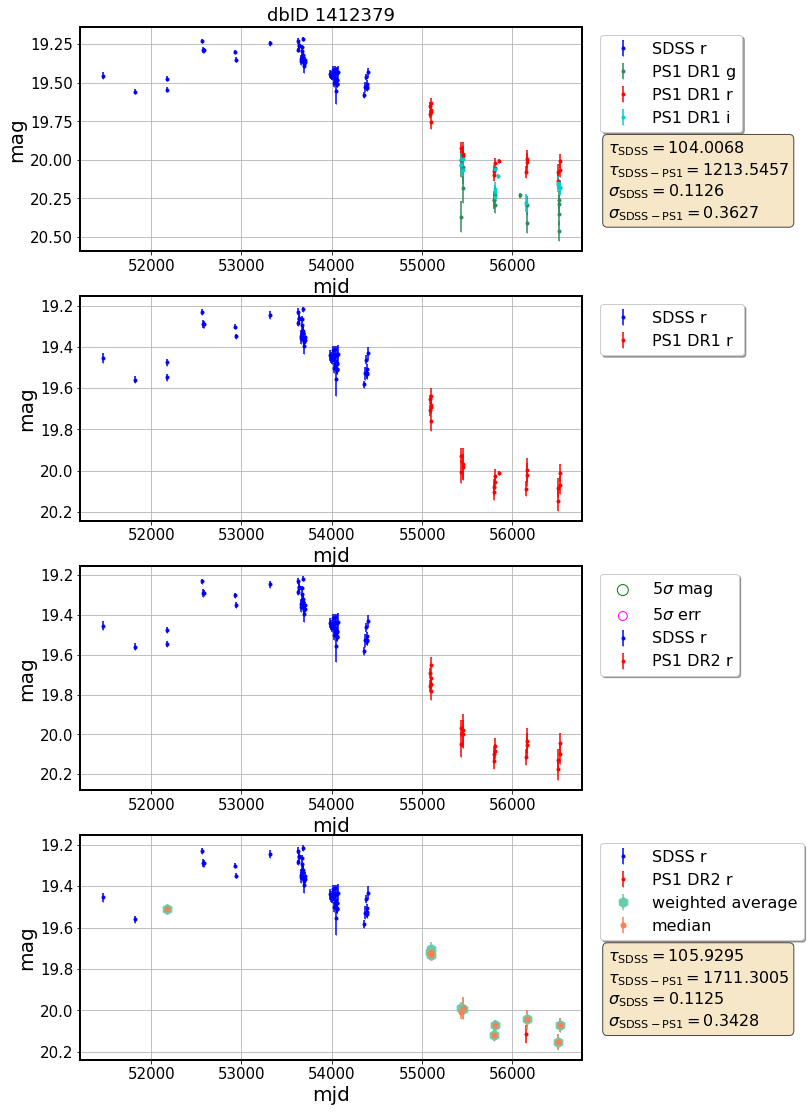

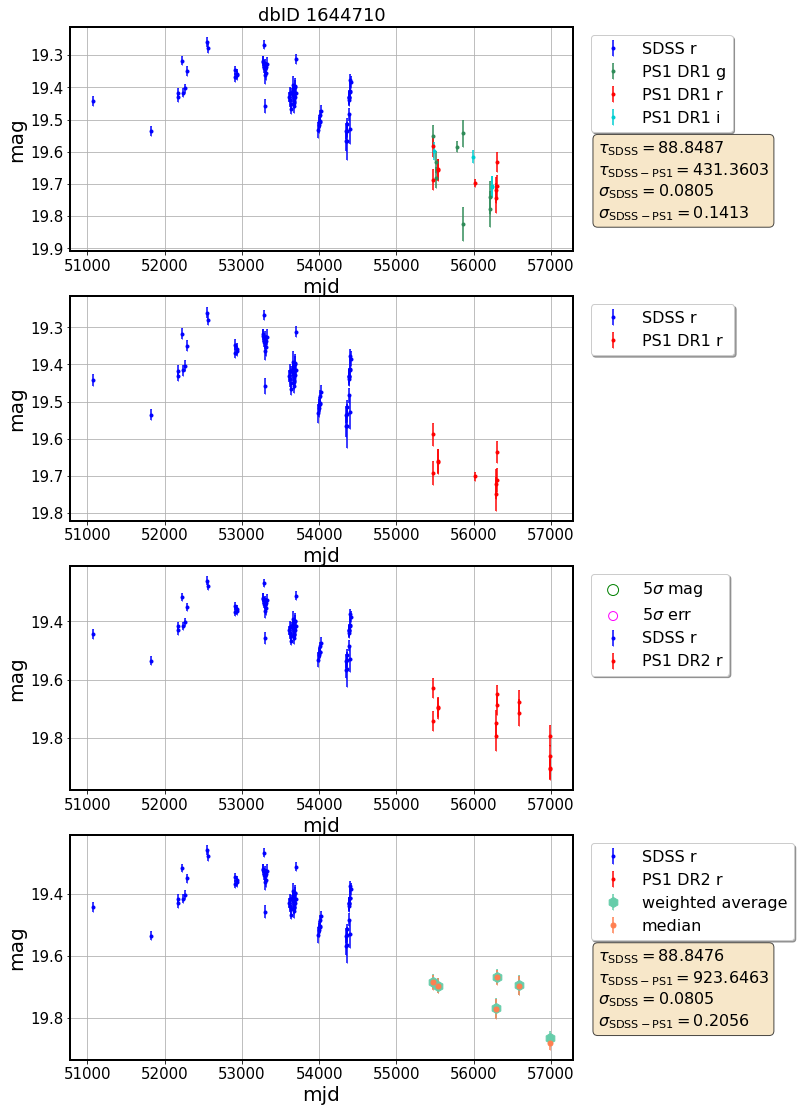

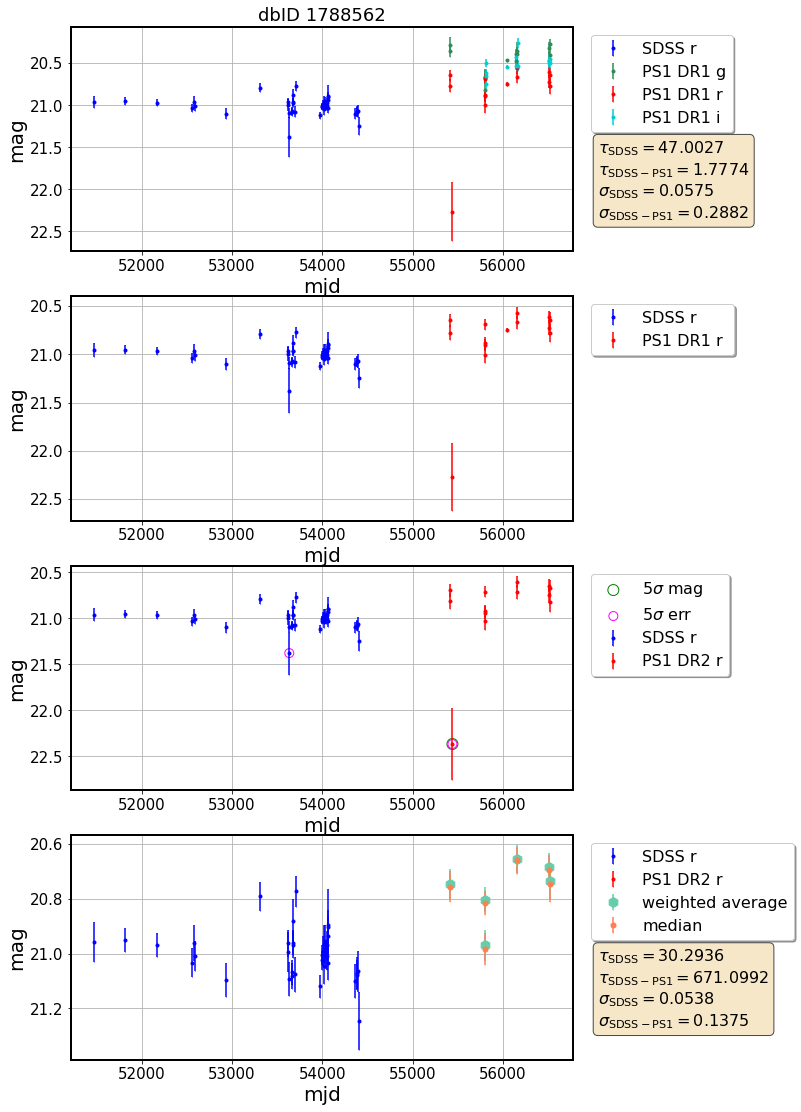

In [103]:
data = Table.read('190606_Celerite_real_Jeff1.txt', format='ascii')
# m2 = data['Plike'] - data['Pnoise'] > 2 
# m3 = data['Plike'] - data['Pinf'] > 0.05 
# m4 = data['edge'] == 0 
# m_sel = m2&m3&m4

x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])

m_ratio = (y>1) & (x>0.4)

#m = m_sel & m_ratio
m  =  m_ratio
print(np.sum(m))
lcnames = data[m_ratio]['lcname'].data

for lcname in lcnames[:10]:
    lc = plot_SDSS_PS1_lc(lcname)

Examples of LCs where things worked just fine: 

Saved as  SDSS_PS1_comp_DR1_DR2_1000679.png
Saved as  SDSS_PS1_comp_DR1_DR2_1000743.png
Saved as  SDSS_PS1_comp_DR1_DR2_1001265.png
Saved as  SDSS_PS1_comp_DR1_DR2_1001294.png


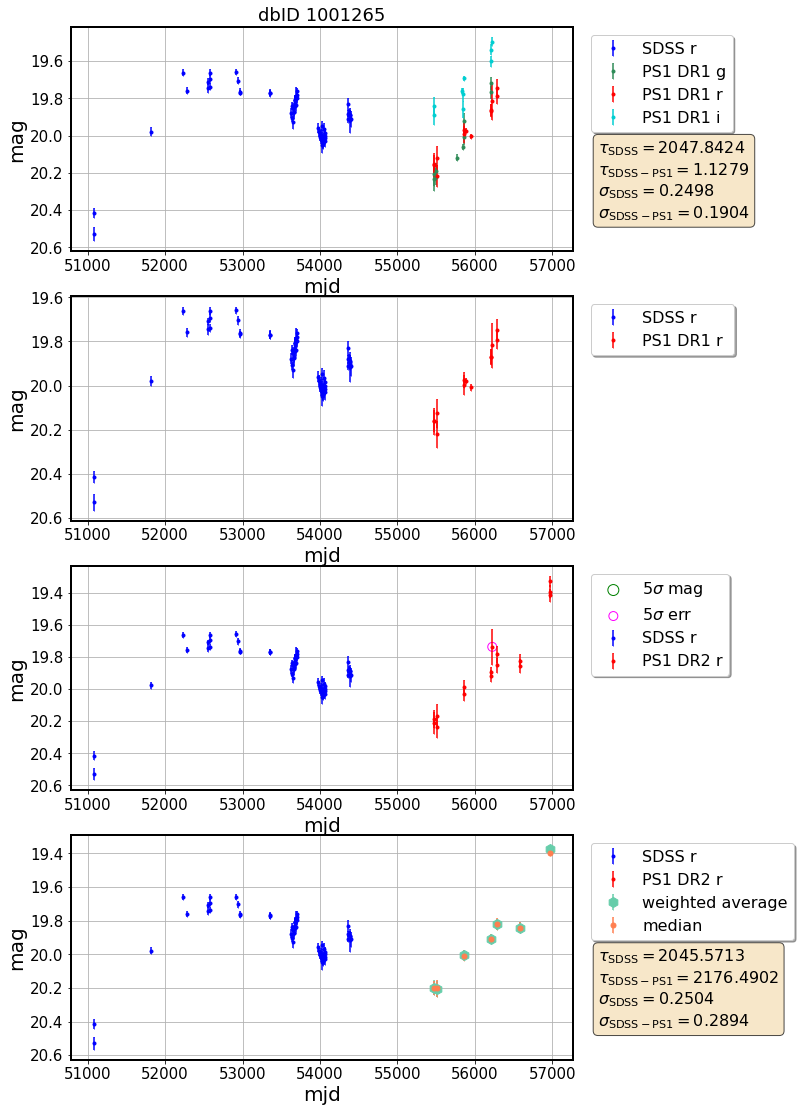

In [49]:
x = np.log10(data['sigmaEXP_sdss-ps1'] / data['sigmaEXP_sdss'])
y = np.log10(data['tauEXP_sdss-ps1'] / data['tauEXP_sdss'])

m = (y>-0.1) & (x<-0.1)

lcnames = data['lcname'].data
for lcname in lcnames[:4]:
    lc = plot_SDSS_PS1_lc(lcname)

In [197]:
d = Table.read('S82_DR7_QSO_PS1_det_suberlak.csv', )
ids = Table.read('S82_DR7_QSO_PS1_objID_suberlak.csv')
# add info about dbID to the detections table from objids table....
det = join(ids['dbID', 'objID'], d)

In [182]:
lc[m]

<Table length=1>
       mag               magerr            mjd      ...  Nobs       medmag     
     float64            float64          float64    ... int64      float64     
----------------- ------------------- ------------- ... ----- -----------------
21.52380668366811 0.14174923679703913 56516.5130814 ...     1 21.52380668366811

In [167]:
lc

<Table length=157>
       mag                magerr        ... mjdint       medmag      
     float64             float64        ... int64       float64      
------------------ -------------------- ... ------ ------------------
            18.148                0.007 ...  51075             18.148
            18.207                0.008 ...  52170             18.207
            18.197                0.008 ...  52196             18.197
            18.204                0.008 ...  52207             18.204
            18.188                0.008 ...  52224             18.188
            18.161                0.008 ...  52231             18.161
            18.139                0.007 ...  52234             18.139
             18.15                0.008 ...  52261              18.15
            18.139                0.008 ...  52282             18.139
             18.17                0.008 ...  52287              18.17
               ...                  ... ...    ...                ...
 18.19912900175995 0.012264272227028224 ...  55467 18.204645419643924
 17.93377487994067  0.05919055889426132 ...  55918  17.97213756148027
18.210161837527902 0.013332623499817422 ...  55467 18.204645419643924
18.278075097606454 0.012385688916885438 ...  55500 18.303592640836996
18.303592640836996 0.012018845418316463 ...  55500 18.303592640836996
 17.97447622816722 0.018423064749135017 ...  55413 17.977959071318306
  17.9500828130902 0.038906078621298607 ...  55414 17.957495442722035
 17.96490807235387  0.04175177978174386 ...  55414 17.957495442722035
18.103532242210218  0.04740408528729841 ...  55076  18.17038695528236
18.237241668354507  0.05726425067851576 ...  55076  18.17038695528236

50780.56704157

In [147]:
max(xlims)

57266.13829703

Illustrate what these light curves look like ... 

In [76]:
def plot_lightcurve(selected, high_variance=True, 
                    input_dir = '../dp2/real_sdss_ps1r_dr2/'):
    #input_dir = '../dp2/real_combined_r/' for s82r 
    lc_real = Table.read(input_dir+selected['lcname'], format='ascii')
    fig,ax = plt.subplots(1,1,figsize=(9,5))

    # plot the observed signal 
    use_segments = 'sdss,ps1'
    colors = ['blue','red']
    j = 0
    labels = ['SDSS r', 'PS1 r']

    for s in use_segments.split(','):
        #rows = lc_real['originSurvey'] == s
        rows = lc_real['survey'] == s 
        # plot the "observed" lc 
        ax.errorbar(lc_real['mjd'][rows], lc_real['mag'][rows], 
                     lc_real['magerr'][rows], fmt=".", capsize=0.2, label=labels[j],
                   c = colors[j])
        j += 1 

    ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )#, loc='upper right')
    textstr = '\n'.join((
        r'$\tau_{\mathrm{SDSS}}=%.4f$' % (selected['tauEXP_sdss'], ),
        r'$\tau_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['tauEXP_sdss-ps1'],),
        r'$\sigma_{\mathrm{SDSS}}=%.4f$' % (selected['sigmaEXP_sdss'], ),
        r'$\sigma_{\mathrm{SDSS-PS1}}=%.4f$' % (selected['sigmaEXP_sdss-ps1'], ),
                        ))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

    # place a text box in upper left in axes coords
    ax.text(1.05, 0.7, textstr, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    ax.set_title('dbId '+selected['lcname'][:-4])
    ax.invert_yaxis()
    ax.set_xlabel('mjd')
    ax.set_ylabel('mag')
    plt.savefig('sdss_ps1_dr2_outliers_'+selected['lcname'][:-4]+'.png',
                bbox_inches='tight')

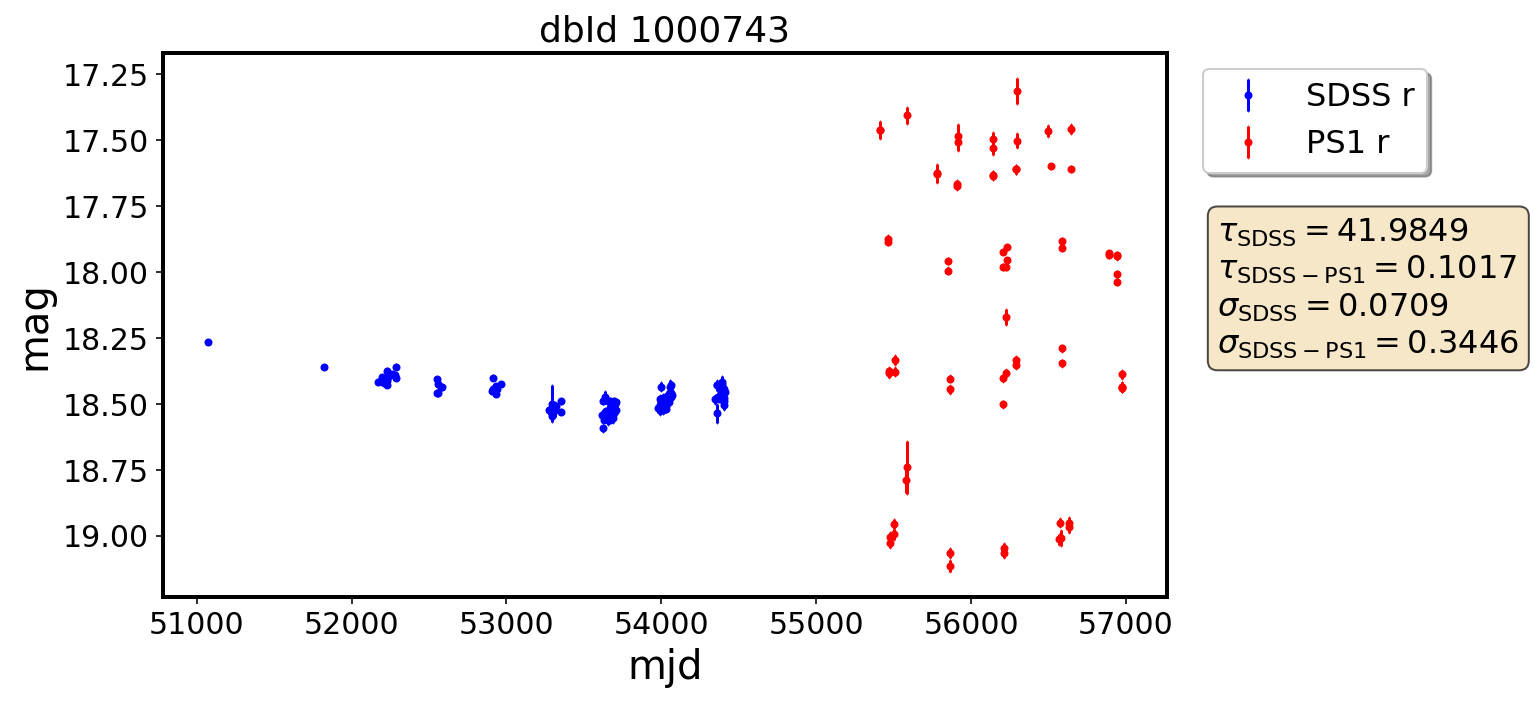

In [77]:
plot_lightcurve(data[m][0])

Investigate in more detail PS1 light curves with much variance on a single night (eg. 27945, 7001, 18792...)

In [117]:
lc_real = Table.read(input_dir+selected['lcname'], format='ascii')

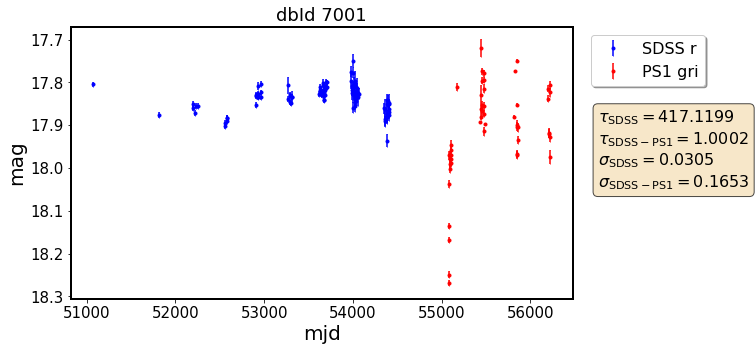

In [123]:
plot_lightcurve(s82r[m][4])

For those LCs that have huge difference in tau and sigma, calculate their intranight variances. This helps find out which LCs may have troubles with PS1 photometry...

In [19]:
# select the light curves that have very low tau and 
# very high sigma ratios .... 
s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
x = np.log10(s82r['sigmaEXP_sdss-ps1'] / s82r['sigmaEXP_sdss'])
y = np.log10(s82r['tauEXP_sdss-ps1'] / s82r['tauEXP_sdss'])
m_ratio = (y<-1) & (x>0.4)



# not all from /real_combined_r/  will have their variances calculated - 
# most light curves are perfectly fine!
input_dir = '../dp2/real_combined_r/'
output_dir = '../dp2/real_combined_r_with_variances/'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)


high_var = {'name':[], 'variance':[]}
sig_threshold = 0.1

for i in range(np.sum(m_ratio)):
    if i % 100 : print(i)
    selected = s82r[m_ratio][i]
    lcname  = selected['lcname']

    # read in the SDSS-PS1 light curve
    lc_real =  Table.read(input_dir+lcname, format='ascii')

    #print(np.unique(lc_real['originSurvey']))

    # Calculate the intra-night sigmaG to estimate the nightly variance,
    # within points coming only from the PS1 survey, to find problems ...
    lc_real['PS1_night_sigG'] =  lc_real['magerr'].astype(float) * 0
    lc_real['mjd_int'] = lc_real['mjd'].astype(int)
    
    # choose points only from ps1 
    m_survey = lc_real['originSurvey'] == 'ps1'
    
    # choose nights within the survey that have more than 
    # one observatins  ... 
    mjds,counts  = np.unique(lc_real['mjd_int'][m_survey],
                             return_counts=True)

    for mjd, count in zip(mjds,counts):
        if count > 1 : 
            m_mjd = lc_real['mjd_int'] == mjd 
            # select points that are within a given survey, 
            # within the same night , defined by an 
            # identical integer part of the mjd 
            m = m_survey & m_mjd 
            mag = lc_real['mag'][m].data
            
            # calculate variance using the robust estimate for stdev 
            sigmaG =  0.7413 * (np.percentile(mag,75) -np.percentile(mag,25))
            lc_real['PS1_night_sigG'][m] = sigmaG
            
    # store the LCs if variance on any night is higher than the threshold ...
    sigGmax = 0
    if np.sum(count>1) > 0 : 
        sigGmax = np.max(lc_real['PS1_night_sigG'].data[count>1])
        
    if  sigGmax > sig_threshold  : 
        high_var['name'].append(lcname)
        high_var['variance'].append(sigGmax) 
        
        lc_real.write(output_dir + lcname, format='ascii' , overwrite='True')
        print('Storing ', lcname, ' max sigG is ', sigGmax)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


Storing  1540.txt  max sigG is  1.1340988964690526
1
Storing  2401.txt  max sigG is  0.16104612475399058
2
3
Storing  5158.txt  max sigG is  0.5800327795499967
4
Storing  7001.txt  max sigG is  0.1735051568250006
5
Storing  9746.txt  max sigG is  0.4335939479251966
6
Storing  12317.txt  max sigG is  0.22659131774999883
7
Storing  14323.txt  max sigG is  0.44517363030000007
8
Storing  18562.txt  max sigG is  0.7267708906500013
9
10
Storing  23517.txt  max sigG is  0.207665206056955
11
12
13
Storing  27945.txt  max sigG is  0.29337762930000016
14
Storing  30279.txt  max sigG is  0.1203336474463525
15
Storing  31440.txt  max sigG is  0.13591465263846814
16
Storing  33734.txt  max sigG is  0.13229941637138393
17
Storing  36251.txt  max sigG is  0.2409977565226007
18
Storing  39631.txt  max sigG is  0.6386258728500019
19
Storing  42444.txt  max sigG is  0.6241868724382006
20
Storing  45836.txt  max sigG is  0.1294016986500014
21
Storing  46359.txt  max sigG is  2.112062519380337
22
Storing 

Storing  564056.txt  max sigG is  0.12311683274766635
168
Storing  570234.txt  max sigG is  0.13996647571925797
169
Storing  571901.txt  max sigG is  0.6175521964500007
170
Storing  576116.txt  max sigG is  0.58580824785
171
Storing  580711.txt  max sigG is  0.647751294278035
172
173
Storing  586347.txt  max sigG is  0.9928090052999997
174
175
Storing  594032.txt  max sigG is  1.0342024560000016
176
Storing  596199.txt  max sigG is  0.10703315647500104
177
Storing  598180.txt  max sigG is  0.3672164515228057
178
Storing  598860.txt  max sigG is  0.18571305250900685
179
Storing  599365.txt  max sigG is  0.20131657478461926
180
181
Storing  606744.txt  max sigG is  0.19481599407219719
182
183
Storing  631921.txt  max sigG is  0.6213139233000001
184
185
186
187
Storing  640637.txt  max sigG is  0.9067366623000005
188
Storing  643516.txt  max sigG is  0.17249050244999983
189
190
191
Storing  644509.txt  max sigG is  0.26979910019999975
192
Storing  650620.txt  max sigG is  0.21926653244999

Storing  1305938.txt  max sigG is  0.20204576279999853
337
Storing  1306557.txt  max sigG is  0.2215160072999975
338
Storing  1310034.txt  max sigG is  0.3896002225500004
339
Storing  1310991.txt  max sigG is  0.13006180200259954
340
Storing  1313712.txt  max sigG is  0.1262583625355374
341
Storing  1314106.txt  max sigG is  0.8176813281000003
342
Storing  1318877.txt  max sigG is  0.31121664314999864
343
Storing  1319336.txt  max sigG is  0.12505879260000238
344
Storing  1348042.txt  max sigG is  0.16424746376233468
345
Storing  1357944.txt  max sigG is  1.2187387128000018
346
Storing  1360484.txt  max sigG is  0.28005779707383394
347
Storing  1364210.txt  max sigG is  0.5167350258000023
348
Storing  1369661.txt  max sigG is  0.16962346431886127
349
Storing  1373548.txt  max sigG is  0.30957651690000215
350
Storing  1384953.txt  max sigG is  0.23260035159604275
351
Storing  1385230.txt  max sigG is  0.830507083347199
352
Storing  1396264.txt  max sigG is  0.3407310362374137
353
Storin

Storing  2842904.txt  max sigG is  0.21573047152294322
505
Storing  2868544.txt  max sigG is  0.14434803426203457
506
Storing  2908214.txt  max sigG is  0.4536127575562699
507
Storing  2931147.txt  max sigG is  0.3286827830999983
508
Storing  2954263.txt  max sigG is  0.5448204112656146
509
Storing  2976053.txt  max sigG is  0.10567671554364852
510
511
Storing  3029556.txt  max sigG is  0.30326842454999775
512
Storing  3032670.txt  max sigG is  0.6448090024752856
513
Storing  3039394.txt  max sigG is  0.3306448721925567
514
Storing  3043595.txt  max sigG is  0.18598155647728234
515
Storing  3052267.txt  max sigG is  0.654383116431979
516
Storing  3054780.txt  max sigG is  0.3845546666864533
517
Storing  3058932.txt  max sigG is  0.39990781372500167
518
Storing  3071231.txt  max sigG is  0.7648044379737204
519
Storing  3072081.txt  max sigG is  0.1600811712798059
520
Storing  3094697.txt  max sigG is  0.24440029558287718
521
Storing  3100327.txt  max sigG is  0.3210655549499992
522
Stor

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Storing  3742911.txt  max sigG is  0.5778351956999985
565
Storing  3763662.txt  max sigG is  0.15409940542499942
566
Storing  3767330.txt  max sigG is  0.12083049872007681
567
Storing  3770163.txt  max sigG is  1.083772816350001
568
Storing  3786811.txt  max sigG is  0.10751666677808475
569
570
571
572
Storing  3797437.txt  max sigG is  0.17793383558440717
573
Storing  3804176.txt  max sigG is  0.23314961591688665
574
Storing  3805989.txt  max sigG is  0.19475390330907183
575
576
Storing  3811788.txt  max sigG is  0.35687901855987275
577
Storing  3821073.txt  max sigG is  0.18821337784333741
578
Storing  3821843.txt  max sigG is  0.2270676030000025
579
Storing  3827861.txt  max sigG is  0.5141082292500002
580
Storing  3831587.txt  max sigG is  0.2573376915114541
581
Storing  3853109.txt  max sigG is  0.3313310773499988
582
Storing  3861327.txt  max sigG is  0.18251730650706155
583
Storing  3867070.txt  max sigG is  0.6368364794185817
584
585
Storing  3870573.txt  max sigG is  0.4795226

In [43]:
s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
x = np.log10(s82r['sigmaEXP_sdss-ps1'] / s82r['sigmaEXP_sdss'])
y = np.log10(s82r['tauEXP_sdss-ps1'] / s82r['tauEXP_sdss'])
m_ratio = (y<-1) & (x>0.4)
#plt.scatter(x,y)

extent = [-0.15, 0.85, -1.6, 0.7 ]
    

# main axis : the hexbin 
#ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
#ax1.xaxis.set_major_formatter(plt.NullFormatter())
#ax1.yaxis.set_major_formatter(plt.NullFormatter())
image = plt.hexbin(x,y,extent = extent, gridsize=35, 
      bins='log', vmin=1 , mincnt=2, cmap='magma')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [20]:
np.save('real_combined_r_variances_list', high_var, )

In [41]:
np.sum(m_ratio)

694

In [22]:
len(high_var['name'])

602

In [ ]:
Ok, so 602 ... 

In [33]:
high_var['name']

['1540.txt',
 '2401.txt',
 '5158.txt',
 '7001.txt',
 '9746.txt',
 '12317.txt',
 '14323.txt',
 '18562.txt',
 '23517.txt',
 '27945.txt',
 '30279.txt',
 '31440.txt',
 '33734.txt',
 '36251.txt',
 '39631.txt',
 '42444.txt',
 '45836.txt',
 '46359.txt',
 '46915.txt',
 '62620.txt',
 '63007.txt',
 '66552.txt',
 '77219.txt',
 '78713.txt',
 '81140.txt',
 '87740.txt',
 '91788.txt',
 '100520.txt',
 '100801.txt',
 '103425.txt',
 '103979.txt',
 '104744.txt',
 '106691.txt',
 '113577.txt',
 '115016.txt',
 '118205.txt',
 '124689.txt',
 '126217.txt',
 '129550.txt',
 '129886.txt',
 '131196.txt',
 '131901.txt',
 '133470.txt',
 '135413.txt',
 '138158.txt',
 '138442.txt',
 '140339.txt',
 '144096.txt',
 '149625.txt',
 '152804.txt',
 '154943.txt',
 '155630.txt',
 '156456.txt',
 '162009.txt',
 '166510.txt',
 '167566.txt',
 '169073.txt',
 '177575.txt',
 '189445.txt',
 '197071.txt',
 '201270.txt',
 '203408.txt',
 '203900.txt',
 '208155.txt',
 '211738.txt',
 '213761.txt',
 '231834.txt',
 '237546.txt',
 '243403.txt

In [27]:
# Check out those light curves  with highest variances ... 
lcs = os.listdir(output_dir)

In [32]:
for lcname in high_var['name'][:20] : 
    lc_real =  Table.read(output_dir+lcname, format='ascii')

    m1 = lc_real['originSurvey'] == 'ps1'
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    #m3 = lc_real['mjd'] < 5`5174

    for band in np.unique(lc_real['originBand'][m1]):
        m2 = lc_real['originBand'] == band
        m = m1&m2#&m3
        ax.errorbar(lc_real[m]['mjd'], lc_real[m]['mag'], lc_real[m]['magerr'],
                    fmt=".", capsize=0.2, label='PS1 '+band)
    m = lc_real['PS1_night_sigG'][m1] > 0.1
    ax.scatter(lc_real['mjd'][m1][m], lc_real['mag'][m1][m], s=100, 
               facecolors='none', edgecolors='r', label='')
    ax.invert_yaxis()
    ax.set_title('dBId ' + lcname[:-4])
    ax.legend(fontsize=16)
    plt.savefig('ps1_large_variance_'+lcname[:-4]+'.png', 
               bbox_inches='tight')
    plt.close()

NB : Find out stars nearby to given quasars ... done in Crossmatch_..... notebook (because that's where I was originally crossmatching SDSS to PS1   ... ) . 

Plot only the PS1 part, mark the points belonging to nights where 
 **sigmaG is above a certain threshold (eg. 0.1 )**

In [240]:
m1 = lc_real['originSurvey'] == 'ps1'
fig,ax = plt.subplots(1,1,figsize=(8,4))
#m3 = lc_real['mjd'] < 5`5174

for band in np.unique(lc_real['originBand']):
    m2 = lc_real['originBand'] == band
    m = m1&m2#&m3
    ax.errorbar(lc_real[m]['mjd'], lc_real[m]['mag'], lc_real[m]['magerr'],
                fmt=".", capsize=0.2, label='PS1 '+band)
m = lc_real['night_sigG'] > 0.1
ax.scatter(lc_real['mjd'][m], lc_real['mag'][m], s=100, 
           facecolors='none', edgecolors='r', label='')
ax.invert_yaxis()
ax.set_title('dBId ' + lcname[:-4])
ax.legend(fontsize=16)
plt.savefig('ps1_large_variance_'+lcname[:-4]+'.png', 
           bbox_inches='tight')

In [ ]:
# this proves the point:  mjd starts at midnight, not noon like JD,
# because MJD = JD - 2400000.5   - the 0.5 shifts 
# to start from midnight 
from astropy.time import Time
t = Time([55088.9,55089.5 ], format='mjd', )

# so to gather all points from one night , I subtract 0.5 from mjd, 
# and wherever the integer part of mjd is the same, this is the same night 



Color by different integer part of mjd... 

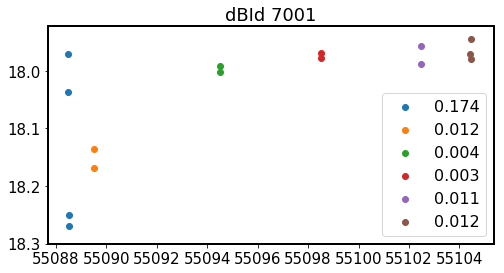

In [227]:
m1 = lc_real['originSurvey'] == 'ps1'
fig,ax = plt.subplots(1,1,figsize=(8,4))
m3 = lc_real['mjd'] < 55174

for mjd in np.unique(lc_real['mjd'][m1&m3].astype(int)):
    m2 = lc_real['mjd'].astype(int) == mjd
    m = m1&m2#&m3
    sigG  = lc_real['night_sigG'][m][0].round(3)
    ax.scatter(lc_real[m]['mjd'], lc_real[m]['mag'], label=sigG)#label=mjd)
ax.invert_yaxis()
ax.set_title('dBId ' + lcname[:-4])
ax.legend(fontsize=16)

Color by different integer part of mjd shifted by 0.5 .... 

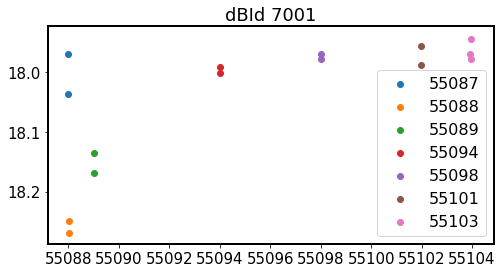

In [181]:
m1 = lc_real['originSurvey'] == 'ps1'
fig,ax = plt.subplots(1,1,figsize=(8,4))
m3 = lc_real['mjd'] < 55174

for mjd in np.unique(lc_real['mjd_noon'][m1&m3].astype(int)):
    m2 = lc_real['mjd_noon'].astype(int) == mjd
    m = m1&m2&m3
    ax.scatter(lc_real[m]['mjd_noon'], lc_real[m]['mag'], label=mjd)
ax.invert_yaxis()
ax.set_title('dBId ' + lcname[:-4])
ax.legend(fontsize=16)

But since I don't know for sure according to which "night" was it observed  (PS1 is in hawaii after all), and I don't know the local time (would have 
to pull that info extra from light curves),it looks safer to assume that whenever the **integer part of mjd is the same, then it is the same "night"** 

In [184]:
# Find points with large intra-night variance ...
# this can be done by calculating the aggregates 

lc_real[:4]

#lc_grouped = lc_real.group_by('mjd_int')

In [185]:
lc_real[m]

<Table length=3>
       mag           magerr     mjd    originBand originSurvey  mjd_noon mjd_int
     float64        float64   float64     str1        str4      float64   int64 
------------------ --------- --------- ---------- ------------ --------- -------
17.970435864646905 0.0103201 55104.429          r          ps1 55103.929   55104
17.978685864646906 0.0110826 55104.439          r          ps1 55103.939   55104
17.945027864646907 0.0109767 55104.461          r          ps1 55103.961   55104

In [224]:
lc_real[lc_real['night_sigG'] > 0]

<Table length=45>
       mag           magerr       mjd      ... mjd_int      night_sigG     
     float64        float64     float64    ...  int64        float64       
------------------ ---------- ------------ ... ------- --------------------
            17.806      0.007 53666.245151 ...   53666 0.008154299999996797
            17.828      0.007 53666.337326 ...   53666 0.008154299999996797
17.830126576691445  0.0243678    55449.539 ...   55449  0.04094607614999884
17.719655576691444  0.0205185     55449.55 ...   55449  0.04094607614999884
17.914553576691446 0.00979005    55478.284 ...   55478  0.02863845757499843
17.814490576691444  0.0102025    55478.296 ...   55478  0.02863845757499843
17.903616576691444  0.0102858    55853.334 ...   55853  0.04810706228638619
17.899213576691444  0.0103685    55853.346 ...   55853  0.04810706228638619
17.904797576691447  0.0101992    55859.317 ...   55859 0.010992367050000099
17.934454576691447  0.0103045     55859.33 ...   55859 0.010992367050000099
               ...        ...          ... ...     ...                  ...
17.973887864646905  0.0169893    56222.326 ...   56222  0.08855588452845901
17.926769864646907  0.0115064    56222.337 ...   56222  0.08855588452845901
 17.77420986302346 0.00885298    55452.462 ...   55452  0.00820841489999712
 17.79635586302346  0.0080739    55452.473 ...   55452  0.00820841489999712
 17.79428386302346  0.0077446    55483.298 ...   55483 0.005840332050000254
17.778526863023462 0.00815701     55483.31 ...   55483 0.005840332050000254
 17.81448986302346 0.00821342     56205.46 ...   56205 0.008774397450000844
 17.83816286302346 0.00833489    56205.472 ...   56205 0.008774397450000844
17.823317863023462 0.00997744    56222.301 ...   56222  0.08855588452845901
 17.80640286302346 0.00973778    56222.313 ...   56222  0.08855588452845901

In [213]:
counts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 2, 2, 2, 3, 1, 1,
       2, 2, 2, 2, 4, 2, 1, 1, 1, 1, 1, 4, 2, 2, 2, 4])

In [214]:
mjd

array([51075, 51819, 52196, 52197, 52225, 52231, 52253, 52557, 52558,
       52577, 52578, 52586, 52908, 52910, 52911, 52930, 52931, 52934,
       52935, 52936, 52959, 52962, 52963, 53270, 53272, 53286, 53288,
       53294, 53302, 53312, 53314, 53623, 53626, 53628, 53637, 53638,
       53639, 53654, 53663, 53664, 53666, 53668, 53669, 53670, 53671,
       53673, 53674, 53675, 53676, 53677, 53679, 53680, 53681, 53685,
       53693, 53697, 53700, 53704, 53705, 53974, 53975, 53989, 53990,
       53994, 53997, 53998, 54000, 54005, 54007, 54009, 54010, 54011,
       54012, 54019, 54020, 54025, 54029, 54030, 54035, 54037, 54040,
       54047, 54049, 54053, 54056, 54068, 54348, 54358, 54359, 54365,
       54381, 54382, 54385, 54386, 54387, 54388, 54392, 54403, 54404,
       54405, 54406, 54412, 55088, 55089, 55094, 55098, 55102, 55104,
       55174, 55439, 55447, 55449, 55452, 55453, 55478, 55483, 55487,
       55818, 55825, 55845, 55847, 55853, 55859, 56205, 56206, 56222])

In [200]:
lc_real['night_sigG'][m] = sigmaG

In [201]:
lc_real[m]['night_sigG']

<Column name='night_sigG' dtype='float64' length=4>
0.08855588452845901
0.08855588452845901
0.08855588452845901
0.08855588452845901

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$\\log_{10}{(SF_{\\infty, SDSS-PS1} / SF_{\\infty,  SDSS} )}$')

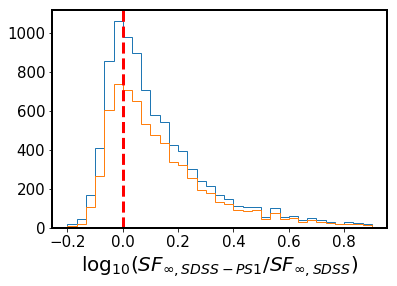

In [20]:
qso =s82r
%matplotlib inline

# impose Chelsea's constraints ... 
m2 = qso['Plike'] - qso['Pnoise'] > 2 
m3 = qso['Plike'] - qso['Pinf'] > 0.05 
m4 = qso['edge'] == 0 
m = m2&m3&m4 


# Compare the two SFinf ...
sfinf1 = qso['sigmaEXP_sdss-ps1'] * np.sqrt(2) # no need to shift anything 
#sf4000_1 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 

sfinf2 = qso['sigmaEXP_sdss'] * np.sqrt(2) # no need to shift anything 
#sf4000_2 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 


plt.hist(np.log10(sfinf1 / sfinf2), bins=33, range=(-0.2, 0.9), histtype='step')
plt.hist(np.log10(sfinf1[m] / sfinf2[m]), bins=33, range=(-0.2, 0.9), histtype='step')

plt.axvline(0, ls='--', lw=3,c='r')
#plt.xlim(-0.3, 0.9)
plt.xlabel(r'$\log_{10}{(SF_{\infty, SDSS-PS1} / SF_{\infty,  SDSS} )}$')
#plt.savefig('Compare_SFinf_4000AA_Celerite.png', bbox_inches='tight', dpi=100)

I'm not  sure if I should expect that there will be a definite trend with the addition of the PS1 data ... 

## Celerite-Chelsea : Fig.13 : distributions of rest-frame $\tau$, and $SF_{\infty}$ <a id='restframeDisCelCh'></a>

In [49]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
m4 = s82r['edge'] == 0 

m = m2&m3&m4


# do the same selection as Chelsea
m1 = (s82r['log10sigmahat'] > -10)*(s82r['log10tau'] > -10)
m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
m4 = s82r['edge'] == 0 
m = m1&m2&m3&m4
print(np.sum(m), ' of ', len(m))
# choose the same extent as Fig.3 MacLeod+2010 
extent = [-1.5,0, 0,5]

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax_legend_handles = []


# If Chelsea's were already RF ... 
# tRF = np.power(10,s82r['log10tau'])
# x = np.log10(s82r['SFinf'])
# y = np.log10(tRF)
# mx = (extent[0] < x) * (x < extent[1])
# my = (extent[2] < y) * (y < extent[3])

# m = mx&my&m1&m2&m3&m4 
# sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
#             linestyles='-', linewidth=2, cmap=None, colors='purple',)
# line = mlines.Line2D([], [],  color='purple', label='ChelseaRF')
# ax_legend_handles.append(line)

# Plot Chelsea's results ( s82rdrw...  - only r-band )
# # assuming tau is obs : conv to restframe by dividing by redshift
red = 'REDSHIFT' # use redshift from Shen2011 ideally ... 
tobs = np.power(10,s82r['log10tau'])
trest = tobs / (1+s82r[red])

x = np.log10(s82r['SFinf'])
y = np.log10(trest) 

mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])

m = mx&my&m1&m2&m3&m4 
print(np.sum(m), ' of ', len(m))

sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
            linestyles='-', linewidth=2, cmap=None, colors='r',)
line = mlines.Line2D([], [],  color='r',ls='-', label='M10 SDSS')
ax_legend_handles.append(line)

 
    
# Plot Celerite results ... 
lss = ['--', '-.']
lw = 2 
i = 0 
for seg,color  in zip(['sdss','sdss-ps1'], ['blue','green']):
    sfinf = np.sqrt(2) * s82r['sigmaEXP_'+seg]
    tauOBS = s82r['tauEXP_'+seg]
    tauRF = tauOBS / (1+s82r[red])
    x = np.log10(sfinf)
    y = np.log10(tauRF)
    m5 = tauOBS > 2
    m = mx&my&m1&m2&m3&m4&m5
    #ax.scatter(x[m], y[m], s=0.05)
    sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
                linestyles=lss[i], lw=lw, cmap=None, colors=color, )
    line = mlines.Line2D([], [],  color=color, lw=lw, ls=lss[i],
                         label='S18 '+seg.upper())
    ax_legend_handles.append(line)
    i += 1 

ax.legend(loc='upper left', handles = ax_legend_handles, bbox_to_anchor=(0,1),
            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 


ax.set_xlabel(r'$\log_{10}{(\mathrm{SF_{\infty}/mag})}$')
ax.set_ylabel(r'$\log_{10}{(\mathrm{\tau_{\mathrm{RF}}/ days})}$')
ax.set_xlim(-1.4, -0.2)
ax.set_ylim(1,3.5)

plt.savefig('MacLeod2010_Fig3_restframe_NEW_.png', bbox_inches='tight', dpi=100)

6867  of  9246
6818  of  9246


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: div

Show the ratio of green (SDSS-PS1) to blue (SDSS) : 
    

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


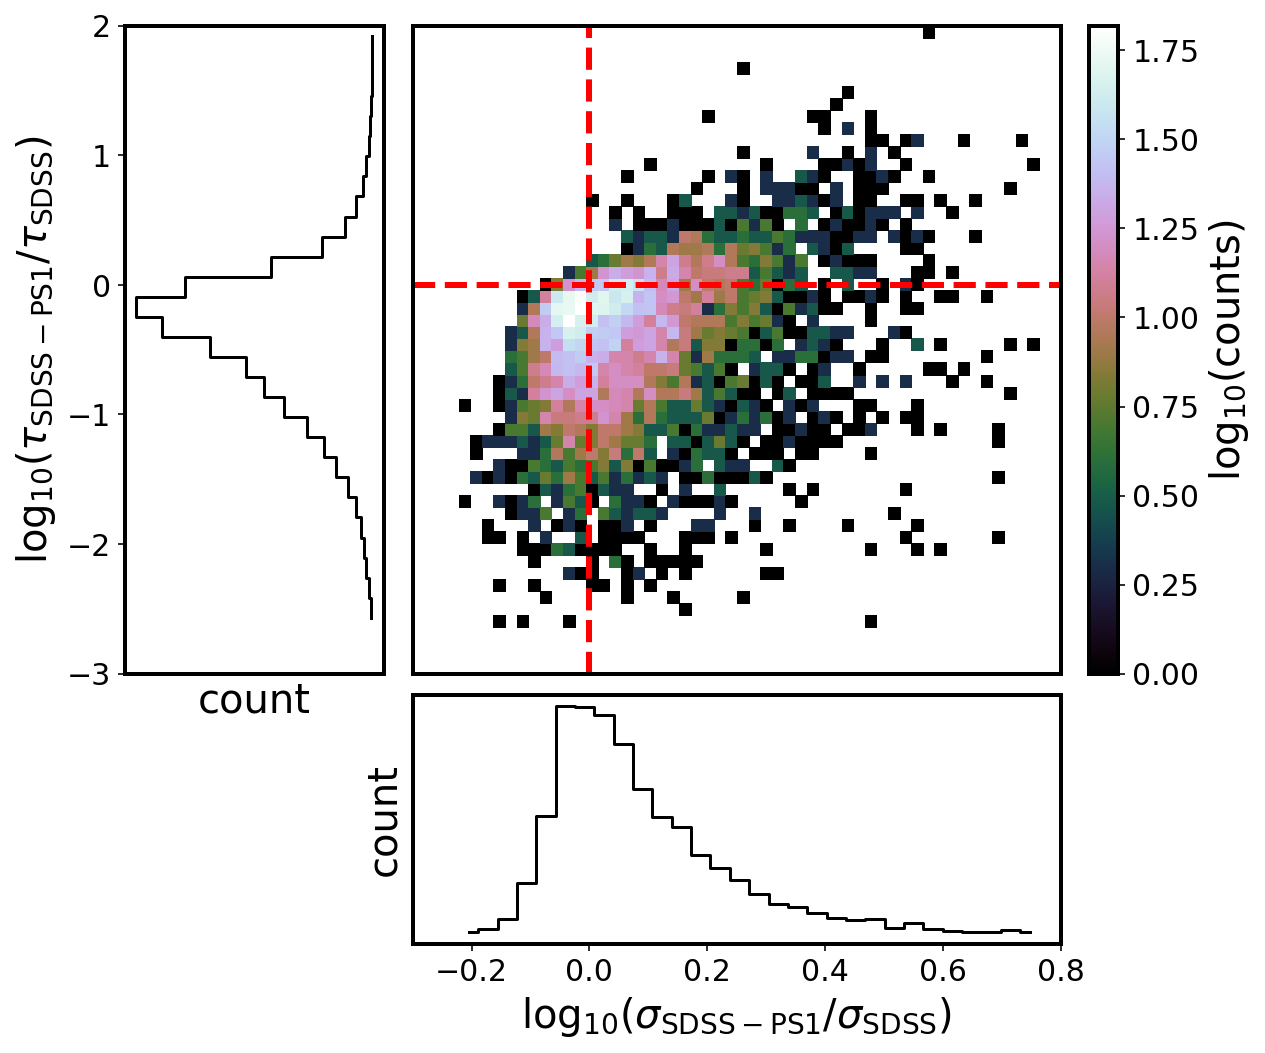

In [62]:
%matplotlib inline

# this code is based on figures 
# http://www.astroml.org/book_figures/chapter5/fig_likelihood_uniform.html#book-fig-chapter5-fig-likelihood-uniform
# and
# http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html#book-fig-chapter5-fig-cauchy-mcmc

from scipy.stats import binned_statistic_2d
fig = plt.figure(figsize=(10, 7.5))

xmin,xmax = -0.3,0.8
ymin,ymax = -3, 2 
# the main plot 
ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
# SFinf_sdss_ps1 / SFinf_sdss = sigma_sdss_ps1 / sigma_sdss
x = np.log10(s82r['sigmaEXP_sdss-ps1'] / s82r['sigmaEXP_sdss'] )
# the redshift correction cancels out 
# tauRF = tauOBS / (1+z)
# tauRF_1  /  tauRF_2  = (tauOBS_1 / (1+z) ) * ((1+z) / tauOBS_2) = 
             # tauOBS_1 / tauOBS_2
y = np.log10(s82r['tauEXP_sdss-ps1']/s82r['tauEXP_sdss']) 

m5 = s82r['tauEXP_sdss-ps1'] > 5


mx = (xmin<x) & (x<xmax)
my = (ymin<y) & (y<ymax)

m = mx&my&m1&m2&m3&m4&m5&mx&my

stats = binned_statistic_2d(x[m], y[m], values = x[m], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,np.log10(z_masked), cmap='cubehelix')  
# np.log10(z_masked) gives log counts
cax = plt.axes([0.82, 0.35, 0.02, 0.6])
cb = plt.colorbar(mappable  = image, cax=cax)
cb.set_label(r'$\log_{10}(\mathrm{counts}) $')
#plt.clim(-7, 0)

ax.axhline(0, lw=3, ls='--', color='red')
ax.axvline(0, lw=3,ls='--', color='red')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

# histograms .. 
bins = 30 
# bottom axis 
ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
hist, bin_edges = np.histogram(x[m], bins=bins)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
ax1.plot(bin_centers, hist,'-k', drawstyle='steps-mid')
ax1.set_xlabel(r'$\log_{10}{(\sigma_{\mathrm{SDSS-PS1}} / \sigma_{\mathrm{SDSS}})}$')
ax1.set_ylabel('count')
ax1.set_xlim(xmin,xmax)


# left axis 
hist, bin_edges = np.histogram(y[m], bins=bins)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
ax2.plot(hist, bin_centers, '-k', drawstyle='steps-mid')
ax2.set_xlabel('count')
ax2.set_ylabel(r'$\log_{10}{(\tau_{\mathrm{SDSS-PS1}} / \tau_{\mathrm{SDSS}})}$')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis
ax2.set_ylim(ymin,ymax)

plt.savefig('Celerite_EXP_J1_ratios_sdss-ps1.png', bbox_inches='tight', dpi=100)

In [51]:
hist, bin_edges = np.histogram(x, bins=50)
(bin_edges[1:]+bin_edges[:-1])/2

array([-2.07227715e-01, -1.72640799e-01, -1.38053883e-01, -1.03466966e-01,
       -6.88800499e-02, -3.42931335e-02,  2.93782848e-04,  3.48806992e-02,
        6.94676156e-02,  1.04054532e-01,  1.38641448e-01,  1.73228365e-01,
        2.07815281e-01,  2.42402198e-01,  2.76989114e-01,  3.11576030e-01,
        3.46162947e-01,  3.80749863e-01,  4.15336779e-01,  4.49923696e-01,
        4.84510612e-01,  5.19097529e-01,  5.53684445e-01,  5.88271361e-01,
        6.22858278e-01,  6.57445194e-01,  6.92032111e-01,  7.26619027e-01,
        7.61205943e-01,  7.95792860e-01,  8.30379776e-01,  8.64966692e-01,
        8.99553609e-01,  9.34140525e-01,  9.68727442e-01,  1.00331436e+00,
        1.03790127e+00,  1.07248819e+00,  1.10707511e+00,  1.14166202e+00,
        1.17624894e+00,  1.21083586e+00,  1.24542277e+00,  1.28000969e+00,
        1.31459661e+00,  1.34918352e+00,  1.38377044e+00,  1.41835735e+00,
        1.45294427e+00,  1.48753119e+00])

In [52]:
bin_edges

array([-0.22452117, -0.18993426, -0.15534734, -0.12076042, -0.08617351,
       -0.05158659, -0.01699968,  0.01758724,  0.05217416,  0.08676107,
        0.12134799,  0.15593491,  0.19052182,  0.22510874,  0.25969566,
        0.29428257,  0.32886949,  0.3634564 ,  0.39804332,  0.43263024,
        0.46721715,  0.50180407,  0.53639099,  0.5709779 ,  0.60556482,
        0.64015174,  0.67473865,  0.70932557,  0.74391249,  0.7784994 ,
        0.81308632,  0.84767323,  0.88226015,  0.91684707,  0.95143398,
        0.9860209 ,  1.02060782,  1.05519473,  1.08978165,  1.12436857,
        1.15895548,  1.1935424 ,  1.22812931,  1.26271623,  1.29730315,
        1.33189006,  1.36647698,  1.4010639 ,  1.43565081,  1.47023773,
        1.50482465])

Take Celerite data for SDSS,  and SDSS+PS1 : fit for the quantities from Table1

Read Chelsea multi-band data into a dictionary ( for MacLeod2011, Fig.13) 

In [32]:
# read in Shen+2011 to add to her resutls ....
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]

# add DBQSO M_i_corr , since it's slightly different than MI_Z2 ...
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)

s82ugriz = {}
# wavelength of observed bandpass 
lambdaobs = {'u':3520, 'g':4800, 'r':6250, 'i':7690, 'z' : 9110 }

for f in 'ugriz':
    s82ugriz[f] = Table.read('../code/s82drw_'+f+'.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
    
    # her selection (chapter 3, macleod2010) was to use only those 
    # where 
    print('\nFor ', f , ' band starting with ', len(s82ugriz[f]))
    m1 = s82ugriz[f]['Npts'] > 10 
    print('Npts>10 ', np.sum(m1))
    m2 = s82ugriz[f]['Plike'] - s82ugriz[f]['Pnoise'] > 2 
    print('Plike - Pnoise  > 2 ' , np.sum(m2))
    m3 = s82ugriz[f]['Plike'] - s82ugriz[f]['Pinf'] > 0.05 
    print('Plike - Pinf > 0.05  ', np.sum(m3))
    m4 = s82ugriz[f]['edge'] == 0 
    print('edge == 0  ', np.sum(m4))
    m = m1&m2&m3&m4
    print('Combined kept : ', np.sum(m))
    s82ugriz[f] = s82ugriz[f][m]
    
    # make a column saying what the middle of the observed filter 
    # corresponds to in QSO rest frame ... ( sec. 5.1)       tface
    s82ugriz[f]['lambdaRF'] = lambdaobs[f] /  (1.+ s82ugriz[f]['redshift'])
    
    # convert tau  to restframe  (SF doesn't need that since amplitude 
    # is not time-dilated )
     
    s82ugriz[f]['SFinf']  = np.power(10,s82ugriz[f]['log10sigmahat']) * \
                  np.sqrt(np.power(10,s82ugriz[f]['log10tau']) / 365.)  
        # # b/c her sigma hat in mag / sqrt(year)  rather than mag / sqrt(days), 
        # and tau is in days 
    s82ugriz[f]['tauRF'] = np.power(10,s82ugriz[f]['log10tau'])  /\
                 (1.+ s82ugriz[f]['redshift'])
    
    # no need to move SFinf to Rest Frame, since it is not affected in the 
    # slightest by using a different frame ... 
    #s82[f]['SFinfRF'] = s82[f]['SFinf'] / (1.+ s82[f]['redshift'])

    
    # make a column with SFinf,  tau  converted to  4000 angstroms using 
    # Chelsea's coefficients 
    s82ugriz[f]['SFinf4000'] = s82ugriz[f]['SFinf'] *\
          np.power(4000 / s82ugriz[f]['lambdaRF'], -0.479)
    s82ugriz[f]['tau4000'] = s82ugriz[f]['tauRF'] *\
        np.power(4000 / s82ugriz[f]['lambdaRF'] , 0.17 )

    
    # add info about Shen+2011   Lbol,  MBH,  etc.  
    cat1 = SkyCoord(ra=s82ugriz[f]['ra']*u.degree, 
                dec=s82ugriz[f]['dec']*u.degree)
    cat2 = SkyCoord(shen2011['RA']*u.degree,shen2011['DEC']*u.degree, 
                       frame='icrs') 
    # grab shen2011 values for BH mass, Lbol, Redshift.... 
    idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
    s82ugriz[f]['d2d_asec_Shen11'] = sep2d.value*3600

    s82ugriz[f]= hstack([s82ugriz[f], shen2011[idx]])

    # add DBQSO 
    cat1 = SkyCoord(ra=s82ugriz[f]['ra']*u.degree, 
                  dec=s82ugriz[f]['dec']*u.degree)
    cat2 = SkyCoord(dbqso['ra']*u.degree,dbqso['dec']*u.degree, 
                       frame='icrs') 
    # add DBQSO 'M_i_corr'
    idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
    s82ugriz[f]['d2d_asec_DBQSO'] = sep2d.value*3600
    s82ugriz[f]= hstack([s82ugriz[f], dbqso[idx][['M_i_corr']]])
   
# save the dictionary ...
np.save('s82ugriz_shen2011_dbqso_dic', s82ugriz)


For  u  band starting with  9258
Npts>10  9135
Plike - Pnoise  > 2  8402
Plike - Pinf > 0.05   7827
edge == 0   8148
Combined kept :  7014

For  g  band starting with  9258
Npts>10  9137
Plike - Pnoise  > 2  9130
Plike - Pinf > 0.05   7641
edge == 0   8180
Combined kept :  7408

For  r  band starting with  9258
Npts>10  9139
Plike - Pnoise  > 2  9128
Plike - Pinf > 0.05   7103
edge == 0   7823
Combined kept :  6871

For  i  band starting with  9258
Npts>10  9138
Plike - Pnoise  > 2  8964
Plike - Pinf > 0.05   7213
edge == 0   7868
Combined kept :  6814

For  z  band starting with  9258
Npts>10  9137
Plike - Pnoise  > 2  7505
Plike - Pinf > 0.05   6719
edge == 0   7365
Combined kept :  5111


## Plot Celerite-Chelsea wavelength dependence of $SF_{\infty}$, $\tau$ <a id='wavelength'></a>

In [51]:
# This is Chelsea ugriz data, x-matched with DBQSO and Shen2011...
s82ugriz = np.load('s82ugriz_shen2011_dbqso_dic.npy').item()

Read Celerite data, overplot on the plot of Fig.13, showing wavelength dependence of timescale and asymptotic amplitude ... 

In [57]:
# This is Celerite x-matched with DBQSO and Chelsea's r-band data 
# earlier:  using 190228  (inner join of SDSS to CRTS,PTF,PS1) , 
# now : using 190409  (outer join of SDSS to CRTS,PTF,PS1, using 2000 more QSO )
s82r = Table.read('190409_Celerite_real_Jeff1_radec_s82drw_r.txt', format='ascii')


## add Shen2011
shen2011 = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
m = shen2011[abs(shen2011['DEC']) < 1.5]
sel = m[['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO', 'MI_Z2' ]]

# cross-match 
cat1 = SkyCoord(ra=s82r['ra_1']*u.degree,  dec=s82r['dec_1']*u.degree)
cat2 = SkyCoord(ra=sel['RA']*u.degree, dec=sel['DEC']*u.degree,  frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
s82r = hstack([s82r, sel[idx]])


# add a column with lambdaRF
lambdaobs = {'u':3520, 'g':4800, 'r':6250, 'i':7690, 'z' : 9110 }
s82r['lambdaRF'] = lambdaobs['r'] /  (1.+ s82r['redshift_1'])    
#s82r

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


sdss red
sdss-ps1 orange


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


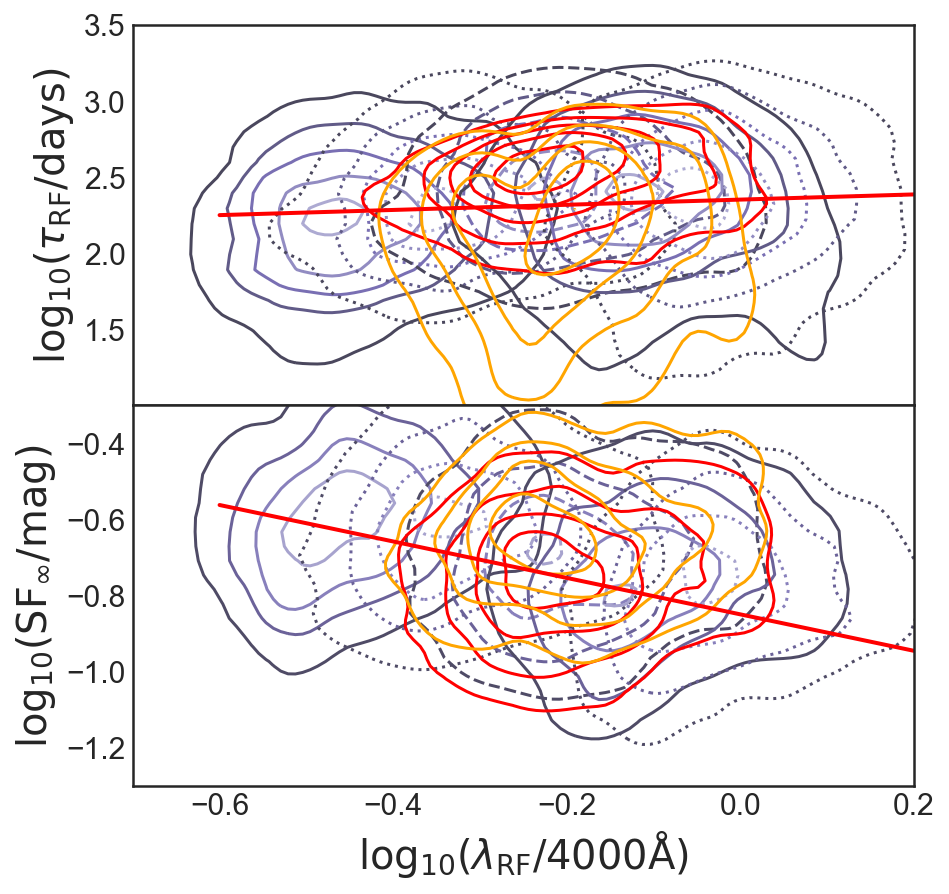

In [58]:
%matplotlib inline
# Make a plot like Fig.13 : 
# rest-frame wavelength  vs tau_RF and SFinf  ... 
def convert_to_stdev(z):
    shape = z.shape
    z = z.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(z)[::-1]
    i_unsort = np.argsort(i_sort)

    z_cumsum = z[i_sort].cumsum()
    z_cumsum /= z_cumsum[-1]

    return z_cumsum[i_unsort].reshape(shape)



ls = {'u':'-',  'g':':', 'r': '--', 'i': '-', 'z': ':' }
lw = {'u':3,    'g': 1,  'r':  2  , 'i': 1  , 'z': 3}
xlims = [-0.7,0.2]
ylims = {0: [1,3.5] , 1:[-1.3,-0.3]}
n_levels = 5 

fig,ax = plt.subplots(2,1,figsize=(7,7))

sns.set_style("white")
# seaborn contour plot line style ...
# https://stackoverflow.com/questions/49671053/seaborn-changing-line-styling-in-kdeplot

seg = 'sdss-ps1' # -ptf

# plot the background of Chelsea's results 
for f in  'ugriz' : 
    x  = np.log10(s82ugriz[f]['lambdaRF'] / 4000 )
    y1 = np.log10(s82ugriz[f]['tauRF'])
    y2 = np.log10(s82ugriz[f]['SFinf']) # np.log10(s82[f]['SFinfRF'])
    
    # Chelsea 
    sns.kdeplot(x,y1, n_levels=n_levels, cmap="Purples_d", ax=ax[0],
               linestyles=ls[f], linewidth=lw[f])
    sns.kdeplot(x,y2, n_levels=n_levels, cmap="Purples_d", ax=ax[1],
               linestyles=ls[f], linewidth=lw[f])

    
# plot Chelsea's fits 
x = np.linspace(-0.6, 0.2, 100)
ax[0].plot(x , 0.17 *  x + 2.35, c='red', lw=2 )
ax[1].plot(x, -0.479 * x - 0.85 , c='red', lw=2)

    
# Celerite : plot sdss and sdss-ps1 
segs = ['sdss', 'sdss-ps1']
for seg, c in zip(segs, ['red', 'orange']):
    print(seg,c)
    tau = s82r['tauEXP_'+seg]

    tauRF = tau / (1. + s82r['redshift_1'])
    SFinf = np.sqrt(2) * s82r['sigmaEXP_'+seg] 

    m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
    m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
    m4 = s82r['edge'] == 0 
    m = m2&m3&m4  #m = tau > 3  

    x = np.log10(s82r['lambdaRF'][m] / 4000)
    y1 = np.log10(tauRF[m])
    y2 = np.log10(SFinf[m])
    sns.kdeplot(x,y1, n_levels=n_levels, ax=ax[0],
               linestyles='-', cmap=None, colors=c)
    sns.kdeplot(x,y2, n_levels=n_levels, ax=ax[1],
               linestyles='-', cmap=None, colors=c)


ax[1].set_xlabel(r'$\log_{10}{(\lambda_{\mathrm{RF}} / 4000 \mathrm{\AA})}$')
ax[0].set_ylabel(r'$\log_{10}{(\tau_{\mathrm{RF}} / \mathrm{days})}$')
ax[1].set_ylabel(r'$\log_{10}{(\mathrm{SF}_{\infty} / \mathrm{mag})}$')
ax[0].set_xlim(xlims)
ax[1].set_xlim(xlims)
ax[0].set_ylim(ylims[0])
ax[1].set_ylim(ylims[1])
# remove bottom tick from first axis 
ax[0].set_yticks(ax[0].get_yticks()[1:])

# remove bottom and top ticks  from second axis 
ax[1].set_yticks(ax[1].get_yticks()[1:-1])

# remove xticks from top axis 
ax[0].set_xticks([])


fig.subplots_adjust(hspace=0)
plt.savefig('macleod2010_Fig13_kdeplot_Chelsea_cut_NEW_.png', 
            bbox_inches='tight', dpi=100)
